# 2022-03-9 Analysis and Plot Generation for Paper

This notebook will be analyzing 100 runs (10 model seeds x 10 datagen seeds) for the one-qubit FPR/GR resource project.
Later in this notebook is the calculations and plot generation for the single qubit fisher information metric results.

In [1]:
from ast import literal_eval
import glob
from IPython.core.display import display, HTML
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
from math import sqrt

import pygsti
from pygsti.baseobjs import Label as L
from pygsti.modelmembers.operations import LindbladErrorgen
from pygsti.tools import optools
from pygsti.protocols import CombinedExperimentDesign
from pygsti.protocols.gst import GateSetTomographyDesign

import scipy as sp
from scipy.optimize import curve_fit
#from sklearn.metrics import r2_score
import time

display(HTML('<style>.container { width:90% !important; }</style>'))

np.set_printoptions(precision = 6, linewidth = 200)

/tmp/ipykernel_2343358/2535083917.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### Data loading ###

In [2]:
data_dir_1 = '../data/data_XYI_L1024/'
data_dir_2 = '../data/data_XYI_L1024_pergerm/'
data_dir_3 = '../data/data_XYI_L1024_pergermrand/'
# This has structure [{fpr key}, {gr key}].for_protocol(model_{model name}_datagen_{datagen index})
#combined_data = pygsti.io.load_results_from_dir(data_dir)

In [3]:
model_pkls = sorted(glob.glob(data_dir_1 + '*.pkl'))

# Keys will be model_name, model_index
noise_models = {}
for mpkl in model_pkls:
    with open(mpkl, 'rb') as f:
        model = pickle.load(f)

    pklname = mpkl.split('/')[-1]
    entries = pklname.split('_')
    model_idx = int(entries[-1].split('.')[0])
    model_name = '_'.join(entries[:-1])
    #print(f'{mpkl}, {pklname}, {entries}, {model_idx}, {model_name}')

    noise_models[(model_name, model_idx)] = model

In [4]:
print(noise_models.keys())

dict_keys([('overrot_XYI_1e-2', 0), ('overrot_XYI_1e-2', 1), ('overrot_XYI_1e-2', 2), ('overrot_XYI_1e-2', 3), ('overrot_XYI_1e-2', 4), ('overrot_XYI_1e-2', 5), ('overrot_XYI_1e-2', 6), ('overrot_XYI_1e-2', 7), ('overrot_XYI_1e-2', 8), ('overrot_XYI_1e-2', 9), ('overrot_XYI_1e-2_global_depol', 0), ('overrot_XYI_1e-2_global_depol', 1), ('overrot_XYI_1e-2_global_depol', 2), ('overrot_XYI_1e-2_global_depol', 3), ('overrot_XYI_1e-2_global_depol', 4), ('overrot_XYI_1e-2_global_depol', 5), ('overrot_XYI_1e-2_global_depol', 6), ('overrot_XYI_1e-2_global_depol', 7), ('overrot_XYI_1e-2_global_depol', 8), ('overrot_XYI_1e-2_global_depol', 9)])


In [5]:
from pygsti.modelpacks import smq1Q_XYI
target_model = smq1Q_XYI.target_model('static')

In [6]:
#load in the experiment designs:
comb_edesign=CombinedExperimentDesign.from_dir(data_dir_1)
edesign_2=GateSetTomographyDesign.from_dir(data_dir_2)
edesign_3= GateSetTomographyDesign.from_dir(data_dir_3)
#I mislabeled things in the edesign generation for the PerGermPower FPR.
#What I had labeled ('Full' , 'Full') in the experiment design and data analysis
#was actually the edesign for the full germ set and per-germ power FPR.
#This probably broke some stuff later down the line for the actual ('Full', 'Full') 
#experiment design since extra data would be getting averaged into due to the concatenation
#of the dataframes. 

#print(edesign_3.keys())

#pull the per-germ power edesigns from edesign_2
comb_edesign['PerGermPower', 'Full']= edesign_2['Full', 'Full']
comb_edesign['PerGermPower', 'Lite']= edesign_2['PerGermPower', 'Lite']

#pull the extra per-germ power random edesigns from edesign_3
comb_edesign['PerGermRand0.03-0', 'Full']= edesign_3['PerGermRand0.03-0', 'Full']
comb_edesign['PerGermRand0.03-0', 'Lite']= edesign_3['PerGermRand0.03-0', 'Lite']
comb_edesign['PerGermRand0.03-0', 'Bare']= edesign_3['PerGermRand0.03-0', 'Bare']
comb_edesign['PerGermRand0.06-0', 'Full']= edesign_3['PerGermRand0.06-0', 'Full']
comb_edesign['PerGermRand0.06-0', 'Lite']= edesign_3['PerGermRand0.06-0', 'Lite']
comb_edesign['PerGermRand0.06-0', 'Bare']= edesign_3['PerGermRand0.06-0', 'Bare']
comb_edesign['PerGermRand0.09-0', 'Full']= edesign_3['PerGermRand0.09-0', 'Full']
comb_edesign['PerGermRand0.09-0', 'Lite']= edesign_3['PerGermRand0.09-0', 'Lite']
comb_edesign['PerGermRand0.09-0', 'Bare']= edesign_3['PerGermRand0.09-0', 'Bare']

In [7]:
print(len(edesign_2[('Full', 'Full')].all_circuits_needing_data))
print(len(edesign_2[('PerGermPower', 'Lite')].all_circuits_needing_data))

535
317


In [8]:
comb_edesign.keys()

dict_keys([('Full', 'Full'), ('Full', 'Lite'), ('PerGermRand0.12-0', 'Full'), ('PerGermRand0.12-0', 'Lite'), ('PerGermRand0.12-0', 'Bare'), ('PerGermRand0.50-0', 'Full'), ('PerGermRand0.50-0', 'Lite'), ('PerGermRand0.50-0', 'Bare'), ('PerGermPower', 'Full'), ('PerGermPower', 'Lite'), ('PerGermRand0.03-0', 'Full'), ('PerGermRand0.03-0', 'Lite'), ('PerGermRand0.03-0', 'Bare'), ('PerGermRand0.06-0', 'Full'), ('PerGermRand0.06-0', 'Lite'), ('PerGermRand0.06-0', 'Bare'), ('PerGermRand0.09-0', 'Full'), ('PerGermRand0.09-0', 'Lite'), ('PerGermRand0.09-0', 'Bare')])

Curious about the number of circuits in each of the designs.

In [9]:
print('Num Ckts Full-Full: ', len(comb_edesign['Full', 'Full'].all_circuits_needing_data))
print('Num Ckts Full-Lite: ', len(comb_edesign['Full', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermPower-Full: ', len(comb_edesign['PerGermPower', 'Full'].all_circuits_needing_data))
print('Num Ckts PerGermPower-Lite: ', len(comb_edesign['PerGermPower', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermPowerRandom 50%-Lite: ', len(comb_edesign['PerGermRand0.50-0', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermPowerRandom 12.5%-Lite: ', len(comb_edesign['PerGermRand0.12-0', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermPowerRandom 8.5%-Lite: ', len(comb_edesign['PerGermRand0.09-0', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermPowerRandom 6%-Lite: ', len(comb_edesign['PerGermRand0.06-0', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermPowerRandom 3%-Lite: ', len(comb_edesign['PerGermRand0.03-0', 'Lite'].all_circuits_needing_data))

Num Ckts Full-Full:  3802
Num Ckts Full-Lite:  1624
Num Ckts PerGermPower-Full:  535
Num Ckts PerGermPower-Lite:  317
Num Ckts PerGermPowerRandom 50%-Lite:  879
Num Ckts PerGermPowerRandom 12.5%-Lite:  275
Num Ckts PerGermPowerRandom 8.5%-Lite:  227
Num Ckts PerGermPowerRandom 6%-Lite:  183
Num Ckts PerGermPowerRandom 3%-Lite:  138


In [10]:
#Load in the Pandas dataframes.
analysis_df= pd.read_hdf('../data/XYI_L1024.partial.h5')
analysis_pergerm_df= pd.read_hdf('../data/XYI_L1024_per_germ.partial.h5')
analysis_pergermrand_df= pd.read_hdf('../data/XYI_L1024_per_germ_rand.partial.h5')

In [11]:
#As mentioned above I mislabeled the ('PerGermPower', 'Full') edesign as ('Full','Full').
#I need to relabel the analysis results in the appropriate dataframe analysis_pergerm_df
analysis_pergerm_df['FPR']= analysis_pergerm_df['FPR'].replace(to_replace='Full', value='PerGermPower')

In [12]:
analysis_pergerm_df

FPR  FPR Index    GR                          Model  \
0     PerGermPower          0  Full               overrot_XYI_1e-2   
1     PerGermPower          0  Full               overrot_XYI_1e-2   
2     PerGermPower          0  Full               overrot_XYI_1e-2   
3     PerGermPower          0  Full               overrot_XYI_1e-2   
4     PerGermPower          0  Full               overrot_XYI_1e-2   
...            ...        ...   ...                            ...   
4795  PerGermPower          0  Lite  overrot_XYI_1e-2_global_depol   
4796  PerGermPower          0  Lite  overrot_XYI_1e-2_global_depol   
4797  PerGermPower          0  Lite  overrot_XYI_1e-2_global_depol   
4798  PerGermPower          0  Lite  overrot_XYI_1e-2_global_depol   
4799  PerGermPower          0  Lite  overrot_XYI_1e-2_global_depol   

     Model Index Datagen Index Parameterization  Num GST Iterations     Gate  \
0              5          2024          full TP                  11       []   
1              5          2024          full TP                  11  Gxpi2:0   
2              5          2024          full TP                  11  Gypi2:0   
3              5          2024             CPTP                  11       []   
4              5          2024             CPTP                  11  Gxpi2:0   
...          ...           ...              ...                 ...      ...   
4795           2          2027           Target                  11  Gxpi2:0   
4796           2          2027           Target                  11  Gypi2:0   
4797           2          2027            Truth                  11       []   
4798           2          2027            Truth                  11  Gxpi2:0   
4799           2          2027            Truth                  11  Gypi2:0   

                                                  L  \
0     [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]   
1     [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]   
2     [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]   
3     [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]   
4     [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]   
...                                             ...   
4795  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]   
4796  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]   
4797  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]   
4798  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]   
4799  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]   

                                                    JTD  \
0     [0.012199959169229151, 0.012672733616632511, 0...   
1     [0.0063132326928788205, 0.004616019720012239, ...   
2     [0.006316741765312845, 0.005645908556347009, 0...   
3     [0.030167902491177886, 0.029208077389025342, 0...   
4     [0.020207852645292748, 0.020503496724172236, 0...   
...                                                 ...   
4795  [0.01421680571246461, 0.01421680571246461, 0.0...   
4796  [0.019923407038811985, 0.019923407038811985, 0...   
4797  [0.02588612269488231, 0.02588612269488231, 0.0...   
4798  [0.02535474426504718, 0.02535474426504718, 0.0...   
4799  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               Eval MAE  \
0     [0.003941133870508434, 0.0025041433229533736, ...   
1     [0.002068523390216329, 0.0021607828349901447, ...   
2     [0.0033559690579230846, 0.0032346532472170065,...   
3     [0.006083940654582405, 0.031818373330280925, 0...   
4     [0.005327646563698727, 0.005561905915169185, 0...   
...                                                 ...   
4795  [0.012908021633165009, 0.012908021633165009, 0...   
4796  [0.01855277299378457, 0.01855277299378457, 0.0...   
4797  [0.003868655654204905, 0.003868655654204905, 0...   
4798  [0.007688152016881946, 0.007688152016881946, 0...   
4799  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                              Angle MAE  \
0     [0.00015675232378923112, 0.001103762049025729,...   
1     [0.0012054

In [13]:
#combine the dataframes into a single data frame object:
combined_frame= pd.concat([analysis_df,analysis_pergerm_df, analysis_pergermrand_df[(analysis_pergermrand_df['FPR']=='PerGermRand0.03') | (analysis_pergermrand_df['FPR']=='PerGermRand0.06') | (analysis_pergermrand_df['FPR']=='PerGermRand0.09') ] ])

In [14]:
#analysis_pergermrand_df[(analysis_pergermrand_df['FPR']=='PerGermRand0.03-0')] #| (analysis_pergermrand_df['FPR']=='PerGermRand0.06-0') | (analysis_pergermrand_df['FPR']=='PerGermRand0.09-0') ] 

In [15]:
#analysis_pergermrand_df['FPR']

In [16]:
combined_frame['FPR'].unique()

array(['Full', 'PerGermRand0.12', 'PerGermRand0.50', 'PerGermPower', 'PerGermRand0.03', 'PerGermRand0.06', 'PerGermRand0.09'], dtype=object)

In [17]:
combined_frame[combined_frame['FPR']=='PerGermRand0.12']['GR'].unique()

array(['Bare', 'Full', 'Lite'], dtype=object)

In [18]:
combined_frame.head()

FPR FPR Index    GR             Model Model Index Datagen Index  \
0  Full         0  Full  overrot_XYI_1e-2           5          2024   
1  Full         0  Full  overrot_XYI_1e-2           5          2024   
2  Full         0  Full  overrot_XYI_1e-2           5          2024   
3  Full         0  Full  overrot_XYI_1e-2           5          2024   
4  Full         0  Full  overrot_XYI_1e-2           5          2024   

  Parameterization  Num GST Iterations     Gate  \
0          full TP                  11       []   
1          full TP                  11  Gxpi2:0   
2          full TP                  11  Gypi2:0   
3             CPTP                  11       []   
4             CPTP                  11  Gxpi2:0   

                                               L  \
0  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]   
1  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]   
2  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]   
3  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]   
4  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]   

                                                 JTD  \
0  [0.01777390425939327, 0.01091308052672946, 0.0...   
1  [0.004337771748749092, 0.006021173656036988, 0...   
2  [0.006260605812981696, 0.0057898178008173075, ...   
3  [0.01763981522506432, 0.012420741853416128, 0....   
4  [0.010131739314871338, 0.010461063145842315, 0...   

                                            Eval MAE  \
0  [0.023200241023815737, 0.012304080859611424, 0...   
1  [0.0002778378208757135, 0.002096965730871359, ...   
2  [0.0034586455379534537, 0.0017583869641634767,...   
3  [0.01977406333341612, 0.003058094510801354, 0....   
4  [0.002251890854150856, 0.0032909548819951865, ...   

                                           Angle MAE  \
0  [0.02213007967051615, 0.012244589669766997, 0....   
1  [7.126504192100924e-06, 0.0019334208860739555,...   
2  [0.003405674149759008, 0.0016809185465403997, ...   
3  [0.019754664429352177, 0.002835816399069627, 0...   
4  [0.002199916071180197, 0.0032909604342474807, ...   

                                        Diamond Dist  
0  [0.035838911751867764, 0.021937867332517312, 0...  
1  [0.00874686295012636, 0.0120771516505224, 0.00...  
2  [0.012551693906198947, 0.011592193442601864, 0...  
3  [0.03533383707607343, 0.024872562648183157, 0....  
4  [0.0204373393211335, 0.020922116254997597, 0.0...

In [19]:
#analysis_df.loc[analysis_df['FPR']=='PerGermRand0.12']

### Calculate Average Diamond Norm Distances ###

In [20]:
#Take as input a dataframe object, FPR type, germ reduction type and parameterization and returned a list of the per iteration diamond distance
#averaged over the gate set for all models and dataset instantiations. This is is flattened with respect the the dataset and noisy model
#instantiations.
#Hardcode in the XYI gateset for now, can update this to pull in the gates from the target model later.
def average_gateset_diamond_distance_periter(dataframe, FPR_type, GR_type, parameterization, split_depol=False):
    """
    if split_depol is true then we separately out the coherent-only and coherent+depolarization model types.
    """    
    #Extract all of the rows from the dataframe object corresponding to the selected FPR_type, GR_type and parameterization.
    extracted_rows= dataframe[(dataframe['FPR']==FPR_type) & (dataframe['GR']==GR_type) & (dataframe['Parameterization']==parameterization)]
    #This returns a dataframe with just the desired rows.
    #Set a list of gate labels.
    gate_labels= ['[]', 'Gxpi2:0', 'Gypi2:0']
    #Now, for each (FPR Index, Model, Model Index, Datagen index) tuple we need to average the diamond distance over the
    #Get unique fpr indices, only relevant for random FPR where we may have multiple random instantiations.
    unique_fpr_indices = extracted_rows['FPR Index'].unique()
    #unique model labels
    unique_model_labels= extracted_rows['Model'].unique()
    #unique model instantiation indexes
    unique_model_indices= extracted_rows['Model Index'].unique()
    #finally, unique data generation instantiations
    unique_datagen_indices= extracted_rows['Datagen Index'].unique()
    
    
    if split_depol==False:
        #just stick the averages into a single list
        avg_gateset_ddists=[]
    else:
        #otherwise we need a nested list for the two model types.
        avg_gateset_ddists1=[]
        avg_gateset_ddists2=[] 
    
    #Now iterate through all of the combinations of these and average over the gates:
    for fpr, mdl_lbl, mdl_idx, datagen_idx in itertools.product(unique_fpr_indices, unique_model_labels, unique_model_indices, unique_datagen_indices):
        #pull out the rows corresponding to these labels/indices:
        rows_to_average= extracted_rows[(extracted_rows['FPR Index']==fpr) & (extracted_rows['Model']==mdl_lbl) & (extracted_rows['Model Index']==mdl_idx) & (extracted_rows['Datagen Index']== datagen_idx)]
        #pull out the diamond distances for these rows and turn them into a numpyarray, on second though I shouldn't actually need to index by gate since that should be the only
        #free parameter left. A quick test confirms this.
        per_gate_ddists= rows_to_average['Diamond Dist']
        avg_gate_ddist= np.asarray(per_gate_ddists.iloc[0])
        for i in range(1,len(per_gate_ddists)):
            avg_gate_ddist += np.asarray(per_gate_ddists.iloc[i])
        avg_gate_ddist= avg_gate_ddist/len(per_gate_ddists)
        #append this to a running list of average diamond distances
        #different behavior here depending on whether we are separating out the two model types.
        
        if split_depol==False:
            avg_gateset_ddists.append(avg_gate_ddist)
        else:
            if 'depol' in mdl_lbl:
                avg_gateset_ddists2.append(avg_gate_ddist)
            else: 
                avg_gateset_ddists1.append(avg_gate_ddist)
    if split_depol==False:
        return avg_gateset_ddists
    else:
        return (avg_gateset_ddists1, avg_gateset_ddists2)    

In [21]:
avg_gateset_ddists_full_full_TP = average_gateset_diamond_distance_periter(combined_frame, 'Full', 'Full', 'full TP', split_depol=True)
#print(avg_gateset_ddists_full_full_TP)

In [22]:
avg_gateset_ddists_full_full_TP_coher, avg_gateset_ddists_full_full_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'Full', 'Full', 'full TP', split_depol=True)
avg_gateset_ddists_full_lite_TP_coher, avg_gateset_ddists_full_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'Full', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermpower_lite_TP_coher, avg_gateset_ddists_pergermpower_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'PerGermPower', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermpower_full_TP_coher, avg_gateset_ddists_pergermpower_full_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'PerGermPower', 'Full', 'full TP', split_depol=True)
avg_gateset_ddists_pergermrand05_lite_TP_coher, avg_gateset_ddists_pergermrand05_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'PerGermRand0.50', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermrand05_bare_TP_coher, avg_gateset_ddists_pergermrand05_bare_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'PerGermRand0.50', 'Bare', 'full TP', split_depol=True)
avg_gateset_ddists_pergermrand012_lite_TP_coher, avg_gateset_ddists_pergermrand012_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'PerGermRand0.12', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermrand012_bare_TP_coher, avg_gateset_ddists_pergermrand012_bare_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'PerGermRand0.12', 'Bare', 'full TP', split_depol=True)
avg_gateset_ddists_pergermrand003_lite_TP_coher, avg_gateset_ddists_pergermrand003_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'PerGermRand0.03', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermrand003_bare_TP_coher, avg_gateset_ddists_pergermrand003_bare_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'PerGermRand0.03', 'Bare', 'full TP', split_depol=True)
avg_gateset_ddists_pergermrand006_lite_TP_coher, avg_gateset_ddists_pergermrand006_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'PerGermRand0.06', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermrand006_bare_TP_coher, avg_gateset_ddists_pergermrand006_bare_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'PerGermRand0.06', 'Bare', 'full TP', split_depol=True)
avg_gateset_ddists_pergermrand009_lite_TP_coher, avg_gateset_ddists_pergermrand009_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'PerGermRand0.09', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermrand009_bare_TP_coher, avg_gateset_ddists_pergermrand009_bare_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'PerGermRand0.09', 'Bare', 'full TP', split_depol=True)

In [23]:
#print(avg_gateset_ddists_full_full_TP_coher)

In [24]:
def plot_ensemble_ddists(ddist_lists, L_dicts, labels, styles, title, ylabel, filename, figure_size=None, 
                         leg_loc=None, ncol=None, leg_fontsize=14):
    
    if figure_size is not None:
        plt.figure(figsize=figure_size)
    
    for ddist_list, L_dict, mdl_styles, mdl_labels in zip(ddist_lists, L_dicts, styles, labels):
        lengths = list(L_dict.keys())
        #print(lengths)
        #print(ddist_list)
        #I don't actually use the index below, not sure why I'm trying to debug this...
#         try:
#             idx = ddist_lists.index(ddist_list)
#         except ValueError as err:
#             print('Encountered Value Error')
#             print(err)
#             #continue
#             print(ddist_list)        
        for i,ys in enumerate(ddist_list):
            #print(i)
            #print(ys)
            ys = np.array(ys)
            if i == 0:
                plt.plot(lengths, ys, mdl_styles, label=mdl_labels)
            else:
                plt.plot(lengths, ys, mdl_styles)

    fit_line = [(1/sqrt(1000))/L for L in lengths]
    
    plt.plot(lengths, fit_line, 'k--', label='Heisenberg Scaling')

    axes = plt.gca()
    axes.set_xscale('log')
    axes.set_xticks(lengths[0:len(lengths):2])
    axes.set_xticklabels([r'$1$', r'$4$', r'$16$', r'$64$', r'$256$', r'$1024$'], fontsize= 22, fontweight='bold')
    #axes.set_xticklabels(lengths[0:len(lengths):2], fontsize= 22, fontweight='bold')
    axes.minorticks_off()
    axes.set_yscale('log')
    axes.set_ylim([1e-5, 1e-1])

    plt.grid()
    #plt.legend(ncol=2, loc='lower left')
    if leg_loc is None:
        if ncol is None:
            plt.legend(loc='upper left', ncol=1, fontsize=leg_fontsize)
        else:
            plt.legend(loc='upper left', ncol=ncol, fontsize=leg_fontsize)
    else:
        if ncol is None:
            plt.legend(loc=leg_loc, ncol=1, fontsize=leg_fontsize)
        else:
            plt.legend(loc=leg_loc, ncol=ncol, fontsize=leg_fontsize)
    plt.title(title, fontsize=16)
    plt.xlabel('$L$ (Max Circuit Depth)', fontsize=24)
    plt.xlim([0.9, lengths[-1]])
    plt.ylabel(ylabel, fontsize=24)
    plt.yticks(fontsize=22)
    plt.tight_layout()
    plt.savefig(filename, facecolor='white', dpi=128)
    plt.show()

In [25]:
def get_shot_counts_by_L(edesign, num_shots=1e4):
    
    ckt_lists= edesign.circuit_lists
    
    #Take the pairwise set differences of each of these circuit lists to get the unique circuits per iteration:
    unique_ckts_by_iter= [ckt_lists[0]]
    
    for i in range(1,len(ckt_lists)):
        unique_ckts_by_iter.append(list(set(ckt_lists[i])-set(ckt_lists[i-1])))
                                   
    #Now put together the dictionary for L vs shots:
    total_shots = 0
    cumul_L_shots = {}
    for i in range(len(ckt_lists)):
        total_shots += len(unique_ckts_by_iter[i])*num_shots
        cumul_L_shots[2**i]= total_shots
                                   
    return cumul_L_shots

In [26]:
ff_shots = get_shot_counts_by_L(comb_edesign['PerGermPower','Lite'], num_shots=1)
print(ff_shots)

{1: 92, 2: 104, 4: 125, 8: 149, 16: 173, 32: 197, 64: 221, 128: 245, 256: 269, 512: 293, 1024: 317}


### Full GR Full FPR Baseline Avg Diamond Distance Plot

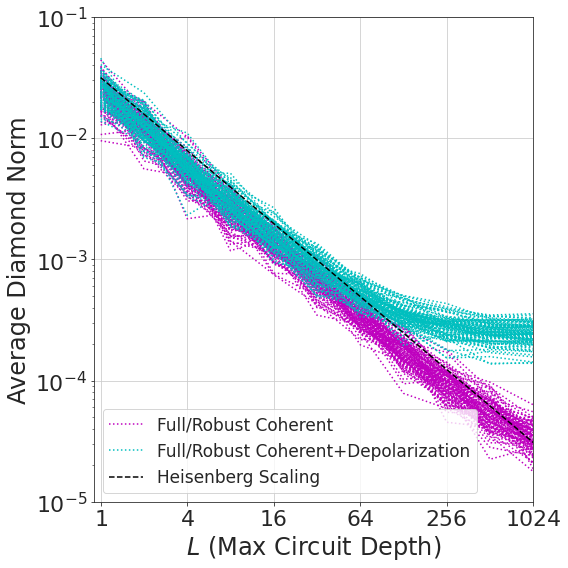

In [27]:
plot_ensemble_ddists([avg_gateset_ddists_full_full_TP_coher, avg_gateset_ddists_full_full_TP_incoher], [ff_shots, ff_shots], 
                     ['Full/Robust Coherent', 'Full/Robust Coherent+Depolarization'], [ 'm:', 'c:'], '', 'Average Diamond Norm',
                     './figure_output/ddist_traces_full_full_TP.png', figure_size=(8,8), leg_loc='lower left', 
                     leg_fontsize=17)

### Lite GR and Full FPR Avg Diamond Distance Plot

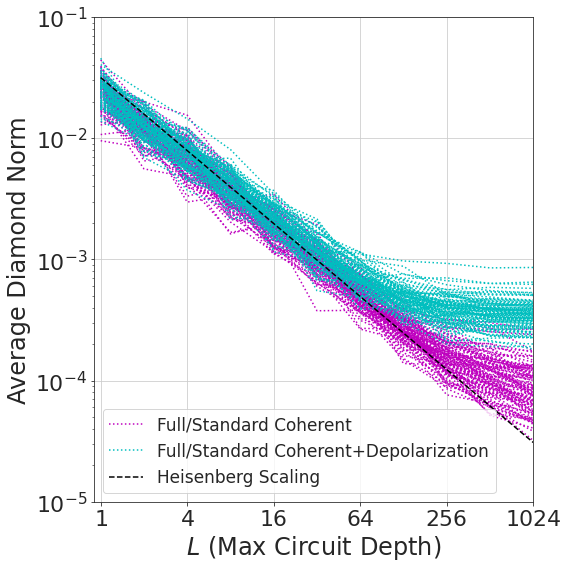

In [28]:
plot_ensemble_ddists([avg_gateset_ddists_full_lite_TP_coher, avg_gateset_ddists_full_lite_TP_incoher], [ff_shots, ff_shots], 
                     ['Full/Standard Coherent', 'Full/Standard Coherent+Depolarization'], [ 'm:', 'c:'], '', 'Average Diamond Norm',
                     './figure_output/ddist_traces_full_lite_TP.png', figure_size=(8,8), leg_loc='lower left',
                     leg_fontsize=17)

### Lite GR and Per-Germ Power FPR Avg Diamond Distance Plot

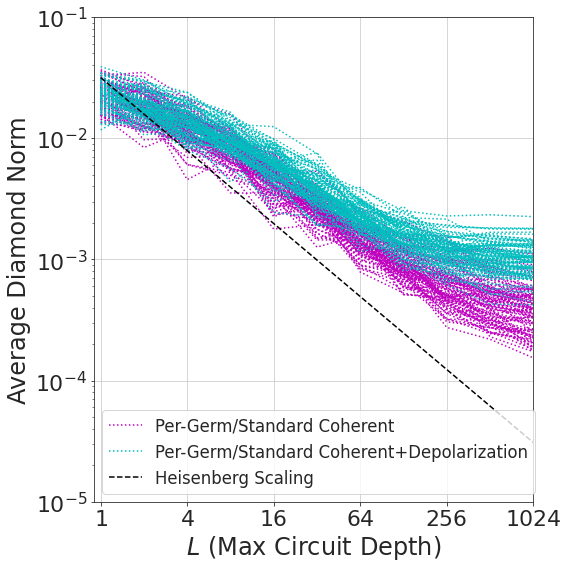

In [29]:
plot_ensemble_ddists([avg_gateset_ddists_pergermpower_lite_TP_coher, avg_gateset_ddists_pergermpower_lite_TP_incoher], [ff_shots, ff_shots], 
                     ['Per-Germ/Standard Coherent', 'Per-Germ/Standard Coherent+Depolarization'], [ 'm:', 'c:'], '', 'Average Diamond Norm',
                     './figure_output/ddist_traces_pergerm_lite_TP.png', figure_size=(8,8), leg_loc='lower left',
                     leg_fontsize=16.5)

### Full GR and Per-Germ Power FPR Avg Diamond Distance Plot

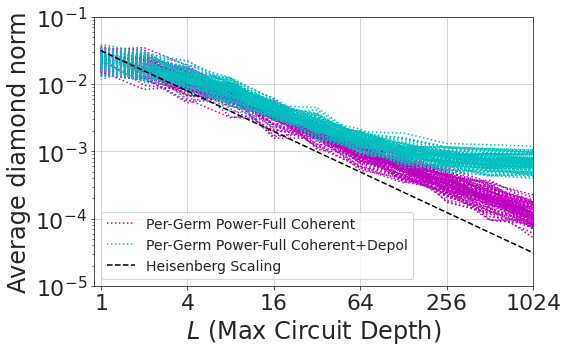

In [30]:
plot_ensemble_ddists([avg_gateset_ddists_pergermpower_full_TP_coher, avg_gateset_ddists_pergermpower_full_TP_incoher], [ff_shots, ff_shots], 
                     ['Per-Germ Power-Full Coherent', 'Per-Germ Power-Full Coherent+Depol'], [ 'm:', 'c:'], '', 'Average diamond norm',
                     './figure_output/test_ddist_pergermpower_full_TP.png', figure_size=(8,5), leg_loc='lower left')

### Lite GR and Per-Germ Power Random 50% FPR Avg Diamond Distance Plot

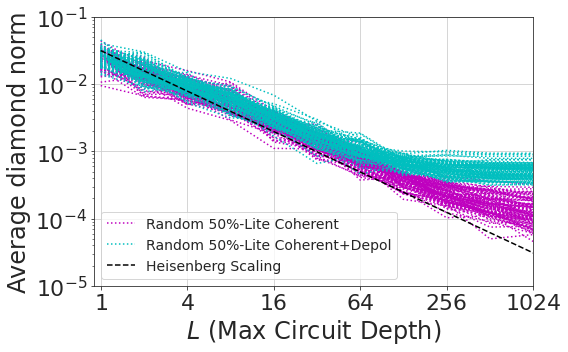

In [31]:
plot_ensemble_ddists([avg_gateset_ddists_pergermrand05_lite_TP_coher, avg_gateset_ddists_pergermrand05_lite_TP_incoher], [ff_shots, ff_shots], 
                     ['Random 50%-Lite Coherent', 'Random 50%-Lite Coherent+Depol'], [ 'm:', 'c:'], '', 'Average diamond norm',
                     './figure_output/test_ddist_pergermrand05_lite_TP.png', figure_size=(8,5), leg_loc='lower left')

### Lite GR and Per-Germ Power Random 12.5% FPR Avg Diamond Distance Plot

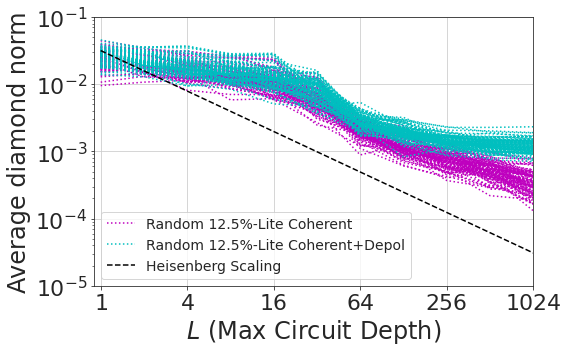

In [32]:
plot_ensemble_ddists([avg_gateset_ddists_pergermrand012_lite_TP_coher, avg_gateset_ddists_pergermrand012_lite_TP_incoher], [ff_shots, ff_shots], 
                     ['Random 12.5%-Lite Coherent', 'Random 12.5%-Lite Coherent+Depol'], [ 'm:', 'c:'], '', 'Average diamond norm',
                     './figure_output/test_ddist_pergermrand012_lite_TP.png', figure_size=(8,5), leg_loc='lower left')

In [33]:
len(list(comb_edesign['PerGermRand0.12-0', 'Lite'].all_circuits_needing_data._additional_circuits))

55

In [34]:
275/535

0.514018691588785

### Bare GR and Per-Germ Power Random 12.5% FPR Avg Diamond Distance Plot

In [35]:
plot_ensemble_ddists([avg_gateset_ddists_pergermrand012_bare_TP_coher, avg_gateset_ddists_pergermrand012_bare_TP_incoher], [ff_shots, ff_shots], 
                     ['Random 12.5%-Bare Coherent', 'Random 12.5%-Bare Coherent+Depol'], [ 'm:', 'c:'], '', 'Average diamond norm',
                     './figure_output/test_ddist_pergermrand012_bare_TP.png', figure_size=(8,5), leg_loc='lower left')

### Bare GR and Per-Germ Power Random 50% FPR Avg Diamond Distance Plot

In [36]:
plot_ensemble_ddists([avg_gateset_ddists_pergermrand05_bare_TP_coher, avg_gateset_ddists_pergermrand05_bare_TP_incoher], [ff_shots, ff_shots], 
                     ['Random 50%-Bare Coherent', 'Random 50%-Bare Coherent+Depol'], [ 'm:', 'c:'], '', 'Average diamond norm',
                     './figure_output/test_ddist_pergermrand05_bare_TP.png', figure_size=(8,5), leg_loc='lower left')

### Lite GR and Per-Germ Power Random 8.5% FPR Avg Diamond Distance Plot

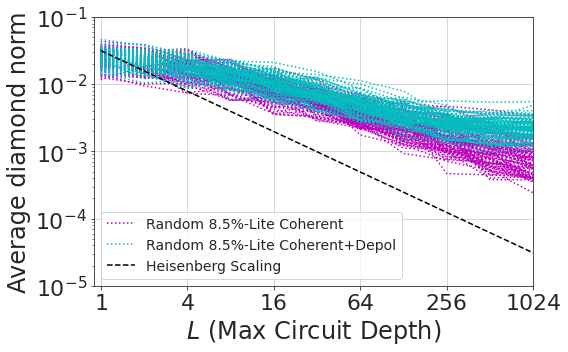

In [37]:
plot_ensemble_ddists([avg_gateset_ddists_pergermrand009_lite_TP_coher, avg_gateset_ddists_pergermrand009_lite_TP_incoher], [ff_shots, ff_shots], 
                     ['Random 8.5%-Lite Coherent', 'Random 8.5%-Lite Coherent+Depol'], [ 'm:', 'c:'], '', 'Average diamond norm',
                     './figure_output/test_ddist_pergermrand009_lite_TP.png', figure_size=(8,5), leg_loc='lower left')

### Lite GR and Per-Germ Power Random 6% FPR Avg Diamond Distance Plot

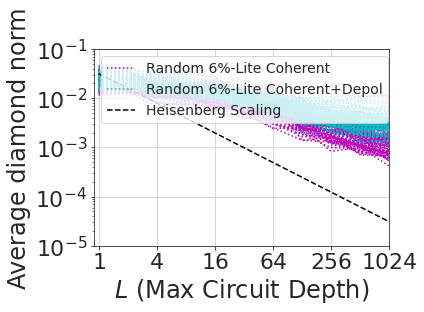

In [38]:
plot_ensemble_ddists([avg_gateset_ddists_pergermrand006_lite_TP_coher, avg_gateset_ddists_pergermrand006_lite_TP_incoher], [ff_shots, ff_shots], 
                     ['Random 6%-Lite Coherent', 'Random 6%-Lite Coherent+Depol'], [ 'm:', 'c:'], '', 'Average diamond norm',
                     './figure_output/test_ddist_pergermrand006_lite_TP.png')

### Lite GR and Per-Germ Power Random 3% FPR Avg Diamond Distance Plot

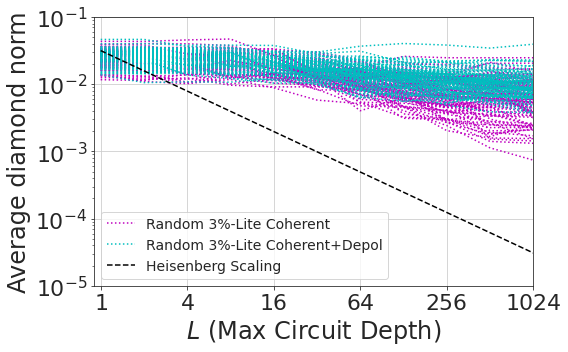

In [39]:
plot_ensemble_ddists([avg_gateset_ddists_pergermrand003_lite_TP_coher, avg_gateset_ddists_pergermrand003_lite_TP_incoher], [ff_shots, ff_shots], 
                     ['Random 3%-Lite Coherent', 'Random 3%-Lite Coherent+Depol'], [ 'm:', 'c:'], '', 'Average diamond norm',
                     './figure_output/test_ddist_pergermrand003_lite_TP.png', figure_size=(8,5), leg_loc='lower left')

## Plots Comparing different Average FPR and GR Schemes on the Same Plot

Start by averaging the per-iteration diamond distance estimates accross each of the instantiations for the traces.

In [40]:
avg_avg_gateset_ddists_full_full_TP_coher = np.mean(np.asarray(avg_gateset_ddists_full_full_TP_coher), axis=0)
avg_avg_gateset_ddists_full_full_TP_incoher = np.mean(np.asarray(avg_gateset_ddists_full_full_TP_incoher), axis=0)
avg_avg_gateset_ddists_full_lite_TP_coher = np.mean(np.asarray(avg_gateset_ddists_full_lite_TP_coher), axis=0)
avg_avg_gateset_ddists_full_lite_TP_incoher = np.mean(np.asarray(avg_gateset_ddists_full_lite_TP_incoher), axis=0)
avg_avg_gateset_ddists_pergermpower_lite_TP_coher = np.mean(np.asarray(avg_gateset_ddists_pergermpower_lite_TP_coher), axis=0)
avg_avg_gateset_ddists_pergermpower_lite_TP_incoher = np.mean(np.asarray(avg_gateset_ddists_pergermpower_lite_TP_incoher), axis=0) 
avg_avg_gateset_ddists_pergermpower_full_TP_coher = np.mean(np.asarray(avg_gateset_ddists_pergermpower_full_TP_coher), axis=0)
avg_avg_gateset_ddists_pergermpower_full_TP_incoher = np.mean(np.asarray(avg_gateset_ddists_pergermpower_full_TP_incoher), axis=0) 
avg_avg_gateset_ddists_pergermrand05_lite_TP_coher = np.mean(np.asarray(avg_gateset_ddists_pergermrand05_lite_TP_coher), axis=0)
avg_avg_gateset_ddists_pergermrand05_lite_TP_incoher = np.mean(np.asarray(avg_gateset_ddists_pergermrand05_lite_TP_incoher), axis=0) 
avg_avg_gateset_ddists_pergermrand05_bare_TP_coher = np.mean(np.asarray(avg_gateset_ddists_pergermrand05_bare_TP_coher), axis=0)
avg_avg_gateset_ddists_pergermrand05_bare_TP_incoher = np.mean(np.asarray(avg_gateset_ddists_pergermrand05_bare_TP_incoher), axis=0)
avg_avg_gateset_ddists_pergermrand012_lite_TP_coher = np.mean(np.asarray(avg_gateset_ddists_pergermrand012_lite_TP_coher), axis=0)
avg_avg_gateset_ddists_pergermrand012_lite_TP_incoher = np.mean(np.asarray(avg_gateset_ddists_pergermrand012_lite_TP_incoher), axis=0) 
avg_avg_gateset_ddists_pergermrand012_bare_TP_coher = np.mean(np.asarray(avg_gateset_ddists_pergermrand012_bare_TP_coher), axis=0)
avg_avg_gateset_ddists_pergermrand012_bare_TP_incoher = np.mean(np.asarray(avg_gateset_ddists_pergermrand012_bare_TP_incoher), axis=0)
avg_avg_gateset_ddists_pergermrand003_lite_TP_coher = np.mean(np.asarray(avg_gateset_ddists_pergermrand003_lite_TP_coher), axis=0)
avg_avg_gateset_ddists_pergermrand003_lite_TP_incoher = np.mean(np.asarray(avg_gateset_ddists_pergermrand003_lite_TP_incoher), axis=0) 
avg_avg_gateset_ddists_pergermrand003_bare_TP_coher = np.mean(np.asarray(avg_gateset_ddists_pergermrand003_bare_TP_coher), axis=0)
avg_avg_gateset_ddists_pergermrand003_bare_TP_incoher = np.mean(np.asarray(avg_gateset_ddists_pergermrand003_bare_TP_incoher), axis=0) 
avg_avg_gateset_ddists_pergermrand006_lite_TP_coher = np.mean(np.asarray(avg_gateset_ddists_pergermrand006_lite_TP_coher), axis=0)
avg_avg_gateset_ddists_pergermrand006_lite_TP_incoher = np.mean(np.asarray(avg_gateset_ddists_pergermrand006_lite_TP_incoher), axis=0) 
avg_avg_gateset_ddists_pergermrand006_bare_TP_coher = np.mean(np.asarray(avg_gateset_ddists_pergermrand006_bare_TP_coher), axis=0)
avg_avg_gateset_ddists_pergermrand006_bare_TP_incoher = np.mean(np.asarray(avg_gateset_ddists_pergermrand006_bare_TP_incoher), axis=0)
avg_avg_gateset_ddists_pergermrand009_lite_TP_coher = np.mean(np.asarray(avg_gateset_ddists_pergermrand009_lite_TP_coher), axis=0)
avg_avg_gateset_ddists_pergermrand009_lite_TP_incoher = np.mean(np.asarray(avg_gateset_ddists_pergermrand009_lite_TP_incoher), axis=0) 
avg_avg_gateset_ddists_pergermrand009_bare_TP_coher = np.mean(np.asarray(avg_gateset_ddists_pergermrand009_bare_TP_coher), axis=0)
avg_avg_gateset_ddists_pergermrand009_bare_TP_incoher = np.mean(np.asarray(avg_gateset_ddists_pergermrand009_bare_TP_incoher), axis=0) 

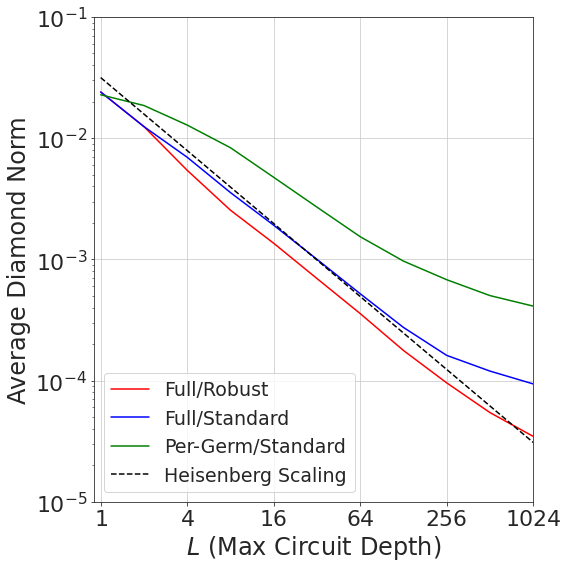

In [41]:
plot_ensemble_ddists([[avg_avg_gateset_ddists_full_full_TP_coher], [avg_avg_gateset_ddists_full_lite_TP_coher], [avg_avg_gateset_ddists_pergermpower_lite_TP_coher]], [ff_shots, ff_shots, ff_shots], 
                     ['Full/Robust', 'Full/Standard', 'Per-Germ/Standard'], [ 'r-', 'b-', 'g-'], '', 'Average Diamond Norm',
                     './figure_output/avg_avg_ddist_fullfull_vs_fulllite_vs_pergermlite_TP.png',
                     figure_size=(8,8), leg_loc='lower left', leg_fontsize=19)

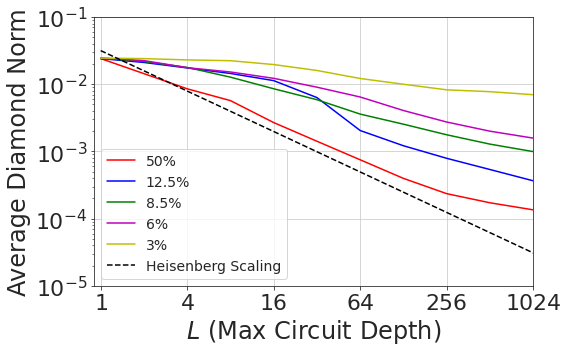

In [42]:
plot_ensemble_ddists([[avg_avg_gateset_ddists_pergermrand05_lite_TP_coher], [avg_avg_gateset_ddists_pergermrand012_lite_TP_coher], 
                     [avg_avg_gateset_ddists_pergermrand009_lite_TP_coher] , [avg_avg_gateset_ddists_pergermrand006_lite_TP_coher] , 
                      [avg_avg_gateset_ddists_pergermrand003_lite_TP_coher]], [ff_shots, ff_shots, ff_shots, ff_shots, ff_shots], 
                     ['50%', '12.5%', '8.5%', '6%', '3%'], [ 'r-', 'b-', 'g-', 'm-', 'y-'], '', 'Average Diamond Norm',
                     './figure_output/avg_avg_ddist_pergermpowerrand_TP.png', figure_size=(8,5), leg_loc='lower left')

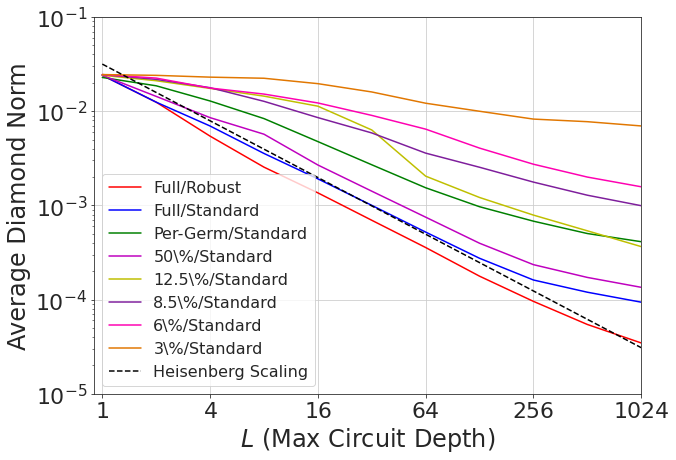

In [43]:
plot_ensemble_ddists([[avg_avg_gateset_ddists_full_full_TP_coher], [avg_avg_gateset_ddists_full_lite_TP_coher], [avg_avg_gateset_ddists_pergermpower_lite_TP_coher],
                      [avg_avg_gateset_ddists_pergermrand05_lite_TP_coher], [avg_avg_gateset_ddists_pergermrand012_lite_TP_coher], 
                     [avg_avg_gateset_ddists_pergermrand009_lite_TP_coher] , [avg_avg_gateset_ddists_pergermrand006_lite_TP_coher] , 
                      [avg_avg_gateset_ddists_pergermrand003_lite_TP_coher]], [ff_shots, ff_shots, ff_shots, ff_shots, ff_shots, ff_shots, ff_shots, ff_shots], 
                     ['Full/Robust', 'Full/Standard', 'Per-Germ/Standard', '50\%/Standard', '12.5\%/Standard', '8.5\%/Standard', '6\%/Standard', '3\%/Standard'], 
                     [ 'r-', 'b-', 'g-', 'm-', 'y-', 'xkcd:purple', 'xkcd:bright pink', 'xkcd:pumpkin'], '', 'Average Diamond Norm',
                     './figure_output/avg_avg_ddist_everything_TP.png', figure_size= (9.5,6.5), leg_loc= 'lower left', ncol=1, leg_fontsize=16)

## Plots Comparing different Average FPR and GR Schemes on the Same Plot (Median Edition)

In [44]:
median_avg_gateset_ddists_full_full_TP_coher = np.median(np.asarray(avg_gateset_ddists_full_full_TP_coher), axis=0)
median_avg_gateset_ddists_full_full_TP_incoher = np.median(np.asarray(avg_gateset_ddists_full_full_TP_incoher), axis=0)
median_avg_gateset_ddists_full_lite_TP_coher = np.median(np.asarray(avg_gateset_ddists_full_lite_TP_coher), axis=0)
median_avg_gateset_ddists_full_lite_TP_incoher = np.median(np.asarray(avg_gateset_ddists_full_lite_TP_incoher), axis=0)
median_avg_gateset_ddists_pergermpower_lite_TP_coher = np.median(np.asarray(avg_gateset_ddists_pergermpower_lite_TP_coher), axis=0)
median_avg_gateset_ddists_pergermpower_lite_TP_incoher = np.median(np.asarray(avg_gateset_ddists_pergermpower_lite_TP_incoher), axis=0) 
median_avg_gateset_ddists_pergermpower_full_TP_coher = np.median(np.asarray(avg_gateset_ddists_pergermpower_full_TP_coher), axis=0)
median_avg_gateset_ddists_pergermpower_full_TP_incoher = np.median(np.asarray(avg_gateset_ddists_pergermpower_full_TP_incoher), axis=0) 
median_avg_gateset_ddists_pergermrand05_lite_TP_coher = np.median(np.asarray(avg_gateset_ddists_pergermrand05_lite_TP_coher), axis=0)
median_avg_gateset_ddists_pergermrand05_lite_TP_incoher = np.median(np.asarray(avg_gateset_ddists_pergermrand05_lite_TP_incoher), axis=0) 
median_avg_gateset_ddists_pergermrand05_bare_TP_coher = np.median(np.asarray(avg_gateset_ddists_pergermrand05_bare_TP_coher), axis=0)
median_avg_gateset_ddists_pergermrand05_bare_TP_incoher = np.median(np.asarray(avg_gateset_ddists_pergermrand05_bare_TP_incoher), axis=0)
median_avg_gateset_ddists_pergermrand012_lite_TP_coher = np.median(np.asarray(avg_gateset_ddists_pergermrand012_lite_TP_coher), axis=0)
median_avg_gateset_ddists_pergermrand012_lite_TP_incoher = np.median(np.asarray(avg_gateset_ddists_pergermrand012_lite_TP_incoher), axis=0) 
median_avg_gateset_ddists_pergermrand012_bare_TP_coher = np.median(np.asarray(avg_gateset_ddists_pergermrand012_bare_TP_coher), axis=0)
median_avg_gateset_ddists_pergermrand012_bare_TP_incoher = np.median(np.asarray(avg_gateset_ddists_pergermrand012_bare_TP_incoher), axis=0)
median_avg_gateset_ddists_pergermrand003_lite_TP_coher = np.median(np.asarray(avg_gateset_ddists_pergermrand003_lite_TP_coher), axis=0)
median_avg_gateset_ddists_pergermrand003_lite_TP_incoher = np.median(np.asarray(avg_gateset_ddists_pergermrand003_lite_TP_incoher), axis=0) 
median_avg_gateset_ddists_pergermrand003_bare_TP_coher = np.median(np.asarray(avg_gateset_ddists_pergermrand003_bare_TP_coher), axis=0)
median_avg_gateset_ddists_pergermrand003_bare_TP_incoher = np.median(np.asarray(avg_gateset_ddists_pergermrand003_bare_TP_incoher), axis=0) 
median_avg_gateset_ddists_pergermrand006_lite_TP_coher = np.median(np.asarray(avg_gateset_ddists_pergermrand006_lite_TP_coher), axis=0)
median_avg_gateset_ddists_pergermrand006_lite_TP_incoher = np.median(np.asarray(avg_gateset_ddists_pergermrand006_lite_TP_incoher), axis=0) 
median_avg_gateset_ddists_pergermrand006_bare_TP_coher = np.median(np.asarray(avg_gateset_ddists_pergermrand006_bare_TP_coher), axis=0)
median_avg_gateset_ddists_pergermrand006_bare_TP_incoher = np.median(np.asarray(avg_gateset_ddists_pergermrand006_bare_TP_incoher), axis=0)
median_avg_gateset_ddists_pergermrand009_lite_TP_coher = np.median(np.asarray(avg_gateset_ddists_pergermrand009_lite_TP_coher), axis=0)
median_avg_gateset_ddists_pergermrand009_lite_TP_incoher = np.median(np.asarray(avg_gateset_ddists_pergermrand009_lite_TP_incoher), axis=0) 
median_avg_gateset_ddists_pergermrand009_bare_TP_coher = np.median(np.asarray(avg_gateset_ddists_pergermrand009_bare_TP_coher), axis=0)
median_avg_gateset_ddists_pergermrand009_bare_TP_incoher = np.median(np.asarray(avg_gateset_ddists_pergermrand009_bare_TP_incoher), axis=0) 

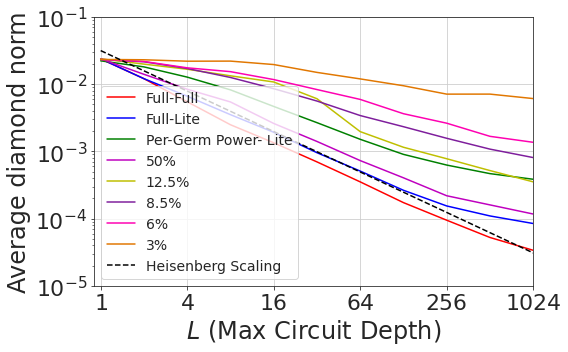

In [45]:
plot_ensemble_ddists([[median_avg_gateset_ddists_full_full_TP_coher], [median_avg_gateset_ddists_full_lite_TP_coher], [median_avg_gateset_ddists_pergermpower_lite_TP_coher],
                      [median_avg_gateset_ddists_pergermrand05_lite_TP_coher], [median_avg_gateset_ddists_pergermrand012_lite_TP_coher], 
                     [median_avg_gateset_ddists_pergermrand009_lite_TP_coher] , [median_avg_gateset_ddists_pergermrand006_lite_TP_coher] , 
                      [median_avg_gateset_ddists_pergermrand003_lite_TP_coher]], [ff_shots, ff_shots, ff_shots, ff_shots, ff_shots, ff_shots, ff_shots, ff_shots], 
                     ['Full-Full', 'Full-Lite', 'Per-Germ Power- Lite','50%', '12.5%', '8.5%', '6%', '3%'], 
                     [ 'r-', 'b-', 'g-', 'm-', 'y-', 'xkcd:purple', 'xkcd:bright pink', 'xkcd:pumpkin'], '', 'Average diamond norm',
                     './figure_output/median_avg_ddist_everything_TP.png', figure_size= (8,5), leg_loc= 'lower left')

# Diamond Distances Split by Gate

In [46]:
#Function for extracting the diamond distance per iteration traces and 
def diamond_distance_per_iter_by_gate(dataframe, FPR_type, GR_type, parameterization, split_depol=False):
    #Extract all of the rows from the dataframe object corresponding to the selected FPR_type, GR_type and parameterization.
    extracted_rows= dataframe[(dataframe['FPR']==FPR_type) & (dataframe['GR']==GR_type) & (dataframe['Parameterization']==parameterization)]
    #This returns a dataframe with just the desired rows.
    #Set a list of gate labels.
    gate_labels= ['[]', 'Gxpi2:0', 'Gypi2:0']
    #Now, for each (FPR Index, Model, Model Index, Datagen index) tuple we need to average the diamond distance over the
    #Get unique fpr indices, only relevant for random FPR where we may have multiple random instantiations.
    unique_fpr_indices = extracted_rows['FPR Index'].unique()
    #unique model labels
    unique_model_labels= extracted_rows['Model'].unique()
    #unique model instantiation indexes
    unique_model_indices= extracted_rows['Model Index'].unique()
    #finally, unique data generation instantiations
    unique_datagen_indices= extracted_rows['Datagen Index'].unique()
    
    if split_depol==False:
        #just stick the diamond distances into a single list per gate
        Gi_ddists=[]
        Gxpi2_ddists=[]
        Gypi2_ddists=[]
    else:
        #otherwise we need a separate list for the two model types.
        Gi_ddists1=[]
        Gxpi2_ddists1=[]
        Gypi2_ddists1=[]
        Gi_ddists2=[]
        Gxpi2_ddists2=[]
        Gypi2_ddists2=[]
    
    #Now iterate through all of the combinations of these and average over the gates:
    for fpr, mdl_lbl, mdl_idx, datagen_idx in itertools.product(unique_fpr_indices, unique_model_labels, unique_model_indices, unique_datagen_indices):
        #pull out the rows corresponding to these labels/indices:
        rows_to_split_off= extracted_rows[(extracted_rows['FPR Index']==fpr) & (extracted_rows['Model']==mdl_lbl) & (extracted_rows['Model Index']==mdl_idx) & (extracted_rows['Datagen Index']== datagen_idx)]
        #pull out the diamond distances for these rows and turn them into a numpyarray, on second though I shouldn't actually need to index by gate since that should be the only
        #free parameter left. A quick test confirms this.
        #append this to a running list of average diamond distances
        #different behavior here depending on whether we are separating out the two model types.
        if split_depol==False:
                Gi_ddists.append(np.asarray(rows_to_split_off[rows_to_split_off['Gate']=='[]']['Diamond Dist'].iloc[0]))
                Gxpi2_ddists.append(np.asarray(rows_to_split_off[rows_to_split_off['Gate']=='Gxpi2:0']['Diamond Dist'].iloc[0]))
                Gypi2_ddists.append(np.asarray(rows_to_split_off[rows_to_split_off['Gate']=='Gypi2:0']['Diamond Dist'].iloc[0]))
        else:
            if 'depol' in mdl_lbl:
                Gi_ddists2.append(np.asarray(rows_to_split_off[rows_to_split_off['Gate']=='[]']['Diamond Dist'].iloc[0]))
                Gxpi2_ddists2.append(np.asarray(rows_to_split_off[rows_to_split_off['Gate']=='Gxpi2:0']['Diamond Dist'].iloc[0]))
                Gypi2_ddists2.append(np.asarray(rows_to_split_off[rows_to_split_off['Gate']=='Gypi2:0']['Diamond Dist'].iloc[0]))
            else: 
                Gi_ddists1.append(np.asarray(rows_to_split_off[rows_to_split_off['Gate']=='[]']['Diamond Dist'].iloc[0]))
                Gxpi2_ddists1.append(np.asarray(rows_to_split_off[rows_to_split_off['Gate']=='Gxpi2:0']['Diamond Dist'].iloc[0]))
                Gypi2_ddists1.append(np.asarray(rows_to_split_off[rows_to_split_off['Gate']=='Gypi2:0']['Diamond Dist'].iloc[0]))
    if split_depol==False:
        return (Gi_ddists, Gxpi2_ddists, Gypi2_ddists)
    else:
        return ((Gi_ddists1, Gxpi2_ddists1, Gypi2_ddists1), (Gi_ddists2, Gxpi2_ddists2, Gypi2_ddists2))

In [47]:
per_gate_ddists_full_full_TP_coher, per_gate_ddists_full_full_TP_incoher = diamond_distance_per_iter_by_gate(combined_frame, 'Full', 'Full', 'full TP', split_depol=True)
per_gate_ddists_full_lite_TP_coher, per_gate_ddists_full_lite_TP_incoher = diamond_distance_per_iter_by_gate(combined_frame, 'Full', 'Lite', 'full TP', split_depol=True)
per_gate_ddists_pergermpower_lite_TP_coher, per_gate_ddists_pergermpower_lite_TP_incoher = diamond_distance_per_iter_by_gate(combined_frame, 'PerGermPower', 'Lite', 'full TP', split_depol=True)
per_gate_ddists_pergermpower_full_TP_coher, per_gate_ddists_pergermpower_full_TP_incoher = diamond_distance_per_iter_by_gate(combined_frame, 'PerGermPower', 'Full', 'full TP', split_depol=True)
per_gate_ddists_pergermrand05_lite_TP_coher, per_gate_ddists_pergermrand05_lite_TP_incoher = diamond_distance_per_iter_by_gate(combined_frame, 'PerGermRand0.50', 'Lite', 'full TP', split_depol=True)
per_gate_ddists_pergermrand05_bare_TP_coher, per_gate_ddists_pergermrand05_bare_TP_incoher = diamond_distance_per_iter_by_gate(combined_frame, 'PerGermRand0.50', 'Bare', 'full TP', split_depol=True)
per_gate_ddists_pergermrand012_lite_TP_coher, per_gate_ddists_pergermrand012_lite_TP_incoher = diamond_distance_per_iter_by_gate(combined_frame, 'PerGermRand0.12', 'Lite', 'full TP', split_depol=True)
per_gate_ddists_pergermrand012_bare_TP_coher, per_gate_ddists_pergermrand012_bare_TP_incoher = diamond_distance_per_iter_by_gate(combined_frame, 'PerGermRand0.12', 'Bare', 'full TP', split_depol=True)
per_gate_ddists_pergermrand003_lite_TP_coher, per_gate_ddists_pergermrand003_lite_TP_incoher = diamond_distance_per_iter_by_gate(combined_frame, 'PerGermRand0.03', 'Lite', 'full TP', split_depol=True)
per_gate_ddists_pergermrand003_bare_TP_coher, per_gate_ddists_pergermrand003_bare_TP_incoher = diamond_distance_per_iter_by_gate(combined_frame, 'PerGermRand0.03', 'Bare', 'full TP', split_depol=True)
per_gate_ddists_pergermrand006_lite_TP_coher, per_gate_ddists_pergermrand006_lite_TP_incoher = diamond_distance_per_iter_by_gate(combined_frame, 'PerGermRand0.06', 'Lite', 'full TP', split_depol=True)
per_gate_ddists_pergermrand006_bare_TP_coher, per_gate_ddists_pergermrand006_bare_TP_incoher = diamond_distance_per_iter_by_gate(combined_frame, 'PerGermRand0.06', 'Bare', 'full TP', split_depol=True)
per_gate_ddists_pergermrand009_lite_TP_coher, per_gate_ddists_pergermrand009_lite_TP_incoher = diamond_distance_per_iter_by_gate(combined_frame, 'PerGermRand0.09', 'Lite', 'full TP', split_depol=True)
per_gate_ddists_pergermrand009_bare_TP_coher, per_gate_ddists_pergermrand009_bare_TP_incoher = diamond_distance_per_iter_by_gate(combined_frame, 'PerGermRand0.09', 'Bare', 'full TP', split_depol=True)

### Full GR Full FPR Baseline Per-Gate Diamond Distance Plot

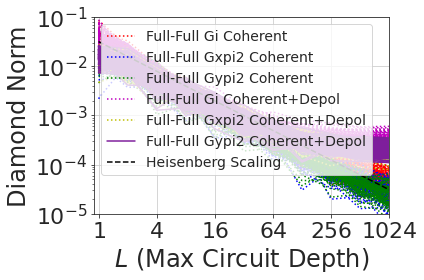

In [48]:
plot_ensemble_ddists([per_gate_ddists_full_full_TP_coher[0], per_gate_ddists_full_full_TP_coher[1], per_gate_ddists_full_full_TP_coher[2], 
                      per_gate_ddists_full_full_TP_incoher[0], per_gate_ddists_full_full_TP_incoher[1], per_gate_ddists_full_full_TP_incoher[2]],
                     [ff_shots, ff_shots,ff_shots, ff_shots,ff_shots, ff_shots], 
                     ['Full-Full Gi Coherent', 'Full-Full Gxpi2 Coherent', 'Full-Full Gypi2 Coherent',
                      'Full-Full Gi Coherent+Depol', 'Full-Full Gxpi2 Coherent+Depol', 'Full-Full Gypi2 Coherent+Depol'],
                     [ 'r:', 'b:', 'g:', 'm:', 'y:', 'xkcd:purple'], '', 'Diamond Norm',
                     './figure_output/per_gate_ddist_full_full_TP.png')

In [49]:
plot_ensemble_ddists([per_gate_ddists_full_full_TP_coher[0], per_gate_ddists_full_full_TP_coher[1], per_gate_ddists_full_full_TP_coher[2]],
                     [ff_shots, ff_shots,ff_shots], 
                     ['Full-Full Gi Coherent', 'Full-Full Gxpi2 Coherent', 'Full-Full Gypi2 Coherent'],
                     [ 'r:', 'b:', 'g:'], '', 'Diamond Norm',
                     './figure_output/per_gate_ddist_full_full_TP_coher.png')

### Lite GR Full FPR Per-Gate Diamond Distance Plot

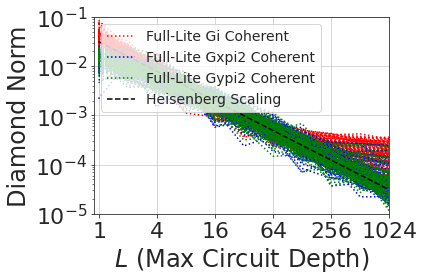

In [50]:
plot_ensemble_ddists([per_gate_ddists_full_lite_TP_coher[0], per_gate_ddists_full_lite_TP_coher[1], per_gate_ddists_full_lite_TP_coher[2]],
                     [ff_shots, ff_shots,ff_shots], 
                     ['Full-Lite Gi Coherent', 'Full-Lite Gxpi2 Coherent', 'Full-Lite Gypi2 Coherent'],
                     [ 'r:', 'b:', 'g:'], '', 'Diamond Norm',
                     './figure_output/per_gate_ddist_full_lite_TP_coher.png')

In [51]:
plot_ensemble_ddists([[np.mean(np.asarray(per_gate_ddists_full_lite_TP_coher[0]),axis=0)], [np.mean(np.asarray(per_gate_ddists_full_lite_TP_coher[1]),axis=0)],
                    [np.mean(np.asarray(per_gate_ddists_full_lite_TP_coher[2]),axis=0)]],
                     [ff_shots, ff_shots,ff_shots], 
                     ['Full/Standard} $G_i$ Coherent', 'Full/Standard} $G_{x_{\pi/2}}$ Coherent', 'Full/Standard} $G_{y_{\pi/2}}$ Coherent'],
                     [ 'r-', 'b-', 'g-'], '', 'Diamond Norm',
                     './figure_output/per_gate_avg_ddist_full_lite_TP_coher.png',
                    figure_size=(9.5,6.5), leg_fontsize=20, leg_loc='lower left')

### Lite GR Per-Germ Power FPR Per-Gate Diamond Distance Plot

In [52]:
plot_ensemble_ddists([per_gate_ddists_pergermpower_lite_TP_coher[0], per_gate_ddists_pergermpower_lite_TP_coher[1], per_gate_ddists_pergermpower_lite_TP_coher[2]],
                     [ff_shots, ff_shots,ff_shots], 
                     [r'Per-Germ Power-Lite $G_i$ Coherent', r'Per-Germ Power-Lite $G_{x_{\pi/2}}$ Coherent', 'Per-Germ Power-Lite Gypi2 Coherent'],
                     [ 'r:', 'b:', 'g:'], '', 'Diamond Norm',
                     './figure_output/per_gate_ddist_pergermpower_lite_TP_coher.png')

Plot average values for the per-gate distributions:

In [53]:
plot_ensemble_ddists([[np.mean(np.asarray(per_gate_ddists_pergermpower_lite_TP_coher[0]),axis=0)], [np.mean(np.asarray(per_gate_ddists_pergermpower_lite_TP_coher[1]),axis=0)],
                    [np.mean(np.asarray(per_gate_ddists_pergermpower_lite_TP_coher[2]),axis=0)]],
                     [ff_shots, ff_shots,ff_shots], 
                     ['Per-Germ Power-Lite Gi Coherent', 'Per-Germ Power-Lite Gxpi2 Coherent', 'Per-Germ Power-Lite Gypi2 Coherent'],
                     [ 'r-', 'b-', 'g-'], '', 'Diamond Norm',
                     './figure_output/per_gate_avg_ddist_pergermpower_lite_TP_coher.png')

## Single Qubit Fisher Information Calculations

In [54]:
#from importlib import reload
#reload(pygsti.tools.edesigntools)
from pygsti.tools.edesigntools import calculate_fisher_information_per_circuit, calculate_fisher_information_matrices_by_L

In [55]:
from pygsti.modelpacks import smq1Q_XYI

In [56]:
#start by precomputing the fisher information matrix terms for the full-full experiment design
#regularize the target model.
regularized_model= smq1Q_XYI.target_model('full TP').depolarize(spam_noise=.001)
fisher_information_ckt_cache= calculate_fisher_information_per_circuit(regularized_model, comb_edesign['Full', 'Full'].all_circuits_needing_data)

In [57]:
print(regularized_model)

rho0 = TPState with dimension 4
 0.71   0   0 0.71


Mdefault = TPPOVM with effect vectors:
0: FullPOVMEffect with dimension 4
 0.71   0   0 0.71

1: ComplementPOVMEffect with dimension 4
 0.71   0   0-0.71



[] = 
FullTPOp with shape (4, 4)
 1.00   0   0   0
   0 1.00   0   0
   0   0 1.00   0
   0   0   0 1.00


Gxpi2:0 = 
FullTPOp with shape (4, 4)
 1.00   0   0   0
   0 1.00   0   0
   0   0   0-1.00
   0   0 1.00   0


Gypi2:0 = 
FullTPOp with shape (4, 4)
 1.00   0   0   0
   0   0   0 1.00
   0   0 1.00   0
   0-1.00   0   0






In [58]:
#print the number of nongauge parameters:
print('Num params total: ', regularized_model.num_params)
print('Num nongauge params: ', regularized_model.num_nongauge_params)
num_gauge= regularized_model.num_params-regularized_model.num_nongauge_params
print('Num gauge params: ', num_gauge)

Num params total:  43
Num nongauge params:  31
Num gauge params:  12


Next we'll start calculating the fisher information matrices by length for various experiment designs.

In [59]:
fisher_info_by_L_full_full =calculate_fisher_information_matrices_by_L(regularized_model, comb_edesign['Full', 'Full'].all_circuits_needing_data, num_shots=1000, term_cache=fisher_information_ckt_cache,
                                               regularize_spam=False, cumulative=True)

In [61]:
#comb_edesign['Full', 'Full'].all_circuits_needing_data._plaquettes

Repeat this for the remaining edesigns

In [62]:
#print(fisher_info_by_L_full_full)

In [63]:
fisher_info_by_L_full_lite =calculate_fisher_information_matrices_by_L(regularized_model, comb_edesign['Full', 'Lite'].all_circuits_needing_data, num_shots=1000, term_cache=fisher_information_ckt_cache,
                                               regularize_spam=False, cumulative=True)
fisher_info_by_L_pergermpower_lite =calculate_fisher_information_matrices_by_L(regularized_model, comb_edesign['PerGermPower', 'Lite'].all_circuits_needing_data, num_shots=1000, term_cache=fisher_information_ckt_cache,
                                               regularize_spam=False, cumulative=True)
fisher_info_by_L_pergermrand05_lite =calculate_fisher_information_matrices_by_L(regularized_model, comb_edesign['PerGermRand0.50-0', 'Lite'].all_circuits_needing_data, num_shots=1000, term_cache=fisher_information_ckt_cache,
                                               regularize_spam=False, cumulative=True)
fisher_info_by_L_pergermrand012_lite =calculate_fisher_information_matrices_by_L(regularized_model, comb_edesign['PerGermRand0.12-0', 'Lite'].all_circuits_needing_data, num_shots=1000, term_cache=fisher_information_ckt_cache,
                                               regularize_spam=False, cumulative=True)
fisher_info_by_L_pergermrand009_lite =calculate_fisher_information_matrices_by_L(regularized_model, comb_edesign['PerGermRand0.09-0', 'Lite'].all_circuits_needing_data, num_shots=1000, term_cache=fisher_information_ckt_cache,
                                               regularize_spam=False, cumulative=True)
fisher_info_by_L_pergermrand006_lite =calculate_fisher_information_matrices_by_L(regularized_model, comb_edesign['PerGermRand0.06-0', 'Lite'].all_circuits_needing_data, num_shots=1000, term_cache=fisher_information_ckt_cache,
                                               regularize_spam=False, cumulative=True)
fisher_info_by_L_pergermrand003_lite =calculate_fisher_information_matrices_by_L(regularized_model, comb_edesign['PerGermRand0.03-0', 'Lite'].all_circuits_needing_data, num_shots=1000, term_cache=fisher_information_ckt_cache,
                                               regularize_spam=False, cumulative=True)
fisher_info_by_L_pergermrand05_bare =calculate_fisher_information_matrices_by_L(regularized_model, comb_edesign['PerGermRand0.50-0', 'Bare'].all_circuits_needing_data, num_shots=1000, term_cache=fisher_information_ckt_cache,
                                               regularize_spam=False, cumulative=True)
fisher_info_by_L_pergermrand012_bare =calculate_fisher_information_matrices_by_L(regularized_model, comb_edesign['PerGermRand0.12-0', 'Bare'].all_circuits_needing_data, num_shots=1000, term_cache=fisher_information_ckt_cache,
                                               regularize_spam=False, cumulative=True)
fisher_info_by_L_pergermrand009_bare =calculate_fisher_information_matrices_by_L(regularized_model, comb_edesign['PerGermRand0.09-0', 'Bare'].all_circuits_needing_data, num_shots=1000, term_cache=fisher_information_ckt_cache,
                                               regularize_spam=False, cumulative=True)
fisher_info_by_L_pergermrand006_bare =calculate_fisher_information_matrices_by_L(regularized_model, comb_edesign['PerGermRand0.06-0', 'Bare'].all_circuits_needing_data, num_shots=1000, term_cache=fisher_information_ckt_cache,
                                               regularize_spam=False, cumulative=True)
fisher_info_by_L_pergermrand003_bare =calculate_fisher_information_matrices_by_L(regularized_model, comb_edesign['PerGermRand0.03-0', 'Bare'].all_circuits_needing_data, num_shots=1000, term_cache=fisher_information_ckt_cache,
                                               regularize_spam=False, cumulative=True)
fisher_info_by_L_pergermrand05_full =calculate_fisher_information_matrices_by_L(regularized_model, comb_edesign['PerGermRand0.50-0', 'Full'].all_circuits_needing_data, num_shots=1000, term_cache=fisher_information_ckt_cache,
                                               regularize_spam=False, cumulative=True)
fisher_info_by_L_pergermrand012_full =calculate_fisher_information_matrices_by_L(regularized_model, comb_edesign['PerGermRand0.12-0', 'Full'].all_circuits_needing_data, num_shots=1000, term_cache=fisher_information_ckt_cache,
                                               regularize_spam=False, cumulative=True)
fisher_info_by_L_pergermrand009_full =calculate_fisher_information_matrices_by_L(regularized_model, comb_edesign['PerGermRand0.09-0', 'Full'].all_circuits_needing_data, num_shots=1000, term_cache=fisher_information_ckt_cache,
                                               regularize_spam=False, cumulative=True)
fisher_info_by_L_pergermrand006_full =calculate_fisher_information_matrices_by_L(regularized_model, comb_edesign['PerGermRand0.06-0', 'Full'].all_circuits_needing_data, num_shots=1000, term_cache=fisher_information_ckt_cache,
                                               regularize_spam=False, cumulative=True)
fisher_info_by_L_pergermrand003_full =calculate_fisher_information_matrices_by_L(regularized_model, comb_edesign['PerGermRand0.03-0', 'Full'].all_circuits_needing_data, num_shots=1000, term_cache=fisher_information_ckt_cache,
                                               regularize_spam=False, cumulative=True)

Now that we have all of the fisher informations we need to extract their spectra and work on processing them

In [64]:
fisher_spectra_by_L_full_full =           [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  fisher_info_by_L_full_full.values()]
fisher_spectra_by_L_full_lite =           [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  fisher_info_by_L_full_lite.values()]
fisher_spectra_by_L_pergermpower_lite   = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  fisher_info_by_L_pergermpower_lite.values()]
fisher_spectra_by_L_pergermrand05_lite  = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  fisher_info_by_L_pergermrand05_lite.values()]
fisher_spectra_by_L_pergermrand012_lite = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  fisher_info_by_L_pergermrand012_lite.values()]
fisher_spectra_by_L_pergermrand009_lite = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  fisher_info_by_L_pergermrand009_lite.values()]
fisher_spectra_by_L_pergermrand006_lite = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  fisher_info_by_L_pergermrand006_lite.values()]
fisher_spectra_by_L_pergermrand003_lite = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  fisher_info_by_L_pergermrand003_lite.values()]
fisher_spectra_by_L_pergermrand05_bare  = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  fisher_info_by_L_pergermrand05_bare.values()]
fisher_spectra_by_L_pergermrand012_bare = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  fisher_info_by_L_pergermrand012_bare.values()]
fisher_spectra_by_L_pergermrand009_bare = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  fisher_info_by_L_pergermrand009_bare.values()]
fisher_spectra_by_L_pergermrand006_bare = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  fisher_info_by_L_pergermrand006_bare.values()]
fisher_spectra_by_L_pergermrand003_bare = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  fisher_info_by_L_pergermrand003_bare.values()]
fisher_spectra_by_L_pergermrand05_full  = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  fisher_info_by_L_pergermrand05_full.values()]
fisher_spectra_by_L_pergermrand012_full = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  fisher_info_by_L_pergermrand012_full.values()]
fisher_spectra_by_L_pergermrand009_full = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  fisher_info_by_L_pergermrand009_full.values()]
fisher_spectra_by_L_pergermrand006_full = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  fisher_info_by_L_pergermrand006_full.values()]
fisher_spectra_by_L_pergermrand003_full = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  fisher_info_by_L_pergermrand003_full.values()]

In [65]:
#print(np.asarray(fisher_spectra_by_L_full_full)[0,:])
#print(fisher_spectra_by_L_full_lite)
print(fisher_spectra_by_L_full_lite)
#print(fisher_spectra_by_L_pergermpower_lite)

[array([-4.974131e-09, -3.200766e-09, -2.147969e-09, -7.468383e-10, -3.634422e-10, -1.882608e-10, -2.234686e-11,  1.485975e-11,  2.214327e-10,  7.902930e-10,  2.728100e-09,  1.523489e-08,
        1.836436e+03,  1.947478e+03,  2.104651e+03,  2.148807e+03,  3.345907e+03,  3.992004e+03,  6.560229e+03,  7.627897e+03,  1.166771e+04,  1.224052e+04,  2.967914e+04,  4.794743e+04,
        4.932974e+04,  7.071515e+04,  1.357283e+05,  1.918127e+05,  5.627466e+05,  7.333703e+05,  1.148423e+06,  1.976136e+06,  1.997001e+06,  1.997001e+06,  2.003967e+06,  2.008556e+06,
        2.064167e+06,  2.076893e+06,  6.928400e+06,  8.356581e+06,  3.469084e+07,  5.842777e+07,  1.282152e+08]), array([-2.329594e-08, -4.902914e-09, -1.248487e-09, -3.976967e-10, -1.175446e-10,  3.574903e-10,  7.768126e-10,  1.787267e-09,  2.339404e-09,  2.752604e-09,  3.361853e-09,  9.238582e-09,
        6.423420e+03,  6.984171e+03,  8.405136e+03,  1.090754e+04,  1.678440e+04,  1.818516e+04,  1.996002e+04,  2.171812e+04,  3.075370e

In [66]:
lengths= [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

We'll plot two cases here, the full spectra and the full spectra minus the number of expected gauge parameters.

In [67]:
def plot_spectra_by_L_sym(fisher_spectra_by_L, Ls, filename, title, figure_size=None):
    
    #convert this spectra to a numpy array
    fisher_array= np.asarray(fisher_spectra_by_L)
    #this should have rows corresponding to the length and columns corresponding to the eigenvalues at that length in increasing order.
    #to get eigenvalue bands we should be able to just take the columns and plot those.
    
    if figure_size is not None:
        plt.figure(figsize=figure_size)
    
    for i in range(fisher_array.shape[1]):
        plt.plot(Ls, fisher_array[:,i])
        
    #also plot a line for the x axis.
    #plt.plot(Ls, [0]*len(Ls),'k')
    
    plt.xscale('log')
    plt.yscale('symlog')
    
    plt.xticks(Ls, Ls)
    
    #Addtional Formatting
    plt.title(title, fontsize=16)
    plt.xlabel(r'$L$, (maximum base circuit depth)', fontsize=16)
    plt.xlim([0.9, lengths[-1]])
    plt.ylabel('Eigenvalue', fontsize=16)

    plt.savefig(filename, facecolor='white', dpi=128)
    plt.show()

In [68]:
def plot_spectra_by_L(fisher_spectra_by_L, Ls, num_gauge, filename, title, figure_size=None):
    #In this version only plot the positive part of the spectra
    
    #convert this spectra to a numpy array
    fisher_array= np.asarray(fisher_spectra_by_L)
    #this should have rows corresponding to the length and columns corresponding to the eigenvalues at that length in increasing order.
    #to get eigenvalue bands we should be able to just take the columns and plot those.
    
    #count how many of the eigenvalues are negative:
    #num_negative= fisher_array[:,i]
    
    #drop the stated number of gauge parameters
    
    
    
    if figure_size is not None:
        plt.figure(figsize=figure_size)
    
    for i in range(num_gauge, fisher_array.shape[1]):
        plt.plot(Ls, fisher_array[:,i])

    #also plot a line for the x axis.
    plt.plot(Ls, [0]*len(Ls), 'k')
    
    axes = plt.gca()
    axes.set_xscale('log')
    axes.set_xticks(lengths[0:len(lengths):2])
    axes.set_xticklabels([r'$1$', r'$4$', r'$16$', r'$64$', r'$256$', r'$1024$'], fontsize= 26, fontweight='bold')
    #axes.set_xticklabels(lengths[0:len(lengths):2], fontsize= 22, fontweight='bold')
    axes.minorticks_off()
    axes.set_yscale('log')
    
    plt.yticks(fontsize=26)
    
    #Addtional Formatting
    plt.title(title, fontsize=16)
    plt.xlabel('L (Max Circuit Depth)', fontsize=26)
    plt.xlim([0.9, lengths[-1]])
    plt.ylabel('Eigenvalue', fontsize=26)
    plt.tight_layout()
    plt.savefig(filename, facecolor='white', dpi=128)
    plt.show()

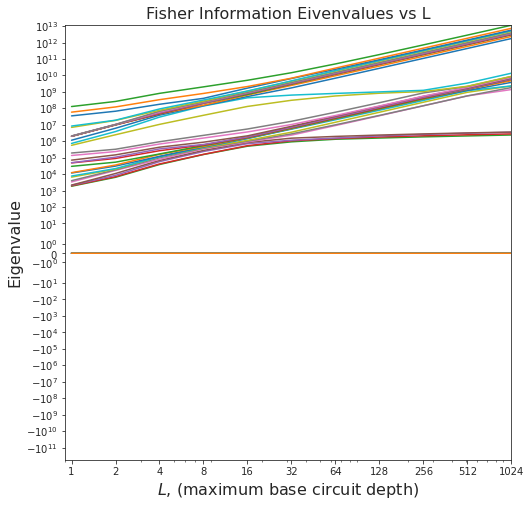

In [69]:
plot_spectra_by_L_sym(fisher_spectra_by_L_full_full,lengths, filename='./figure_output/fisher_info_spectra_sym_full_full.png', title='Fisher Information Eivenvalues vs L',
                      figure_size=(8,8))

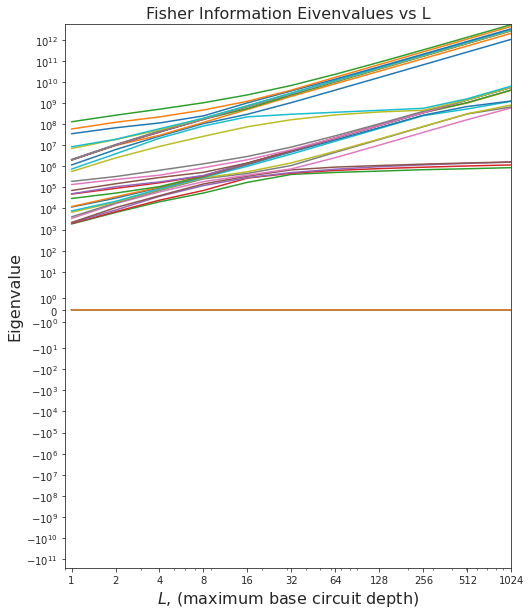

In [70]:
plot_spectra_by_L_sym(fisher_spectra_by_L_full_lite,lengths, filename='./figure_output/fisher_info_spectra_sym_full_lite.png', title='Fisher Information Eivenvalues vs L',
                      figure_size=(8,10))

In [71]:
plot_spectra_by_L_sym(fisher_spectra_by_L_pergermpower_lite,lengths, filename='./figure_output/fisher_info_spectra_sym_pergermpower_lite.png', title='Fisher Information Eivenvalues vs L', figure_size=(8,10))

In [72]:
#print(fisher_spectra_by_L_pergermpower_lite)

### Fisher Spectra With Gauge Dropped

In [73]:
plot_spectra_by_L(fisher_spectra_by_L_full_full,lengths,num_gauge=12, filename='./figure_output/fisher_info_spectra_full_full_fig8.png', title='',
                      figure_size=(8,8))

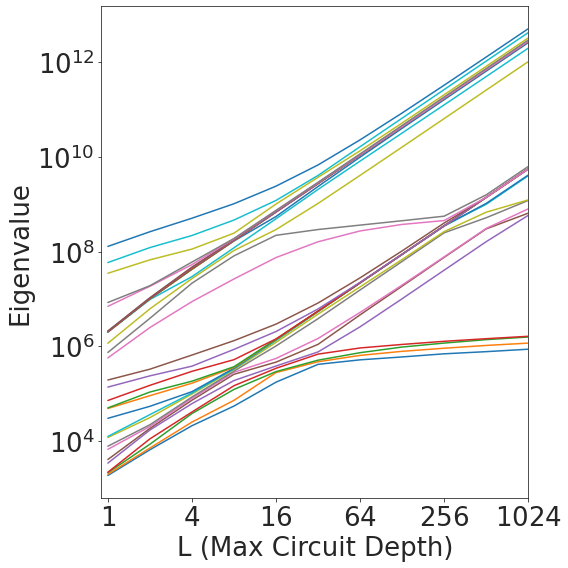

In [74]:
plot_spectra_by_L(fisher_spectra_by_L_full_lite,lengths, num_gauge=12, filename='./figure_output/fisher_info_spectra_full_lite_fig8.png', title='',
                      figure_size=(8,8))

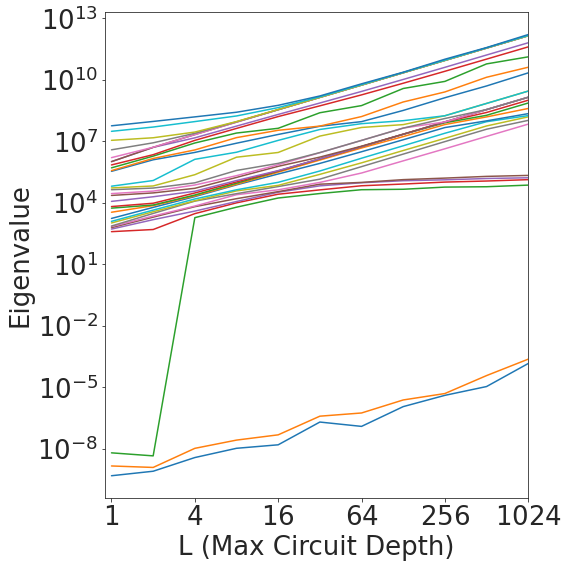

In [75]:
plot_spectra_by_L(fisher_spectra_by_L_pergermpower_lite,lengths, num_gauge=12, filename='./figure_output/fisher_info_spectra_pergerm_lite_fig8.png', title='', figure_size=(8,8))

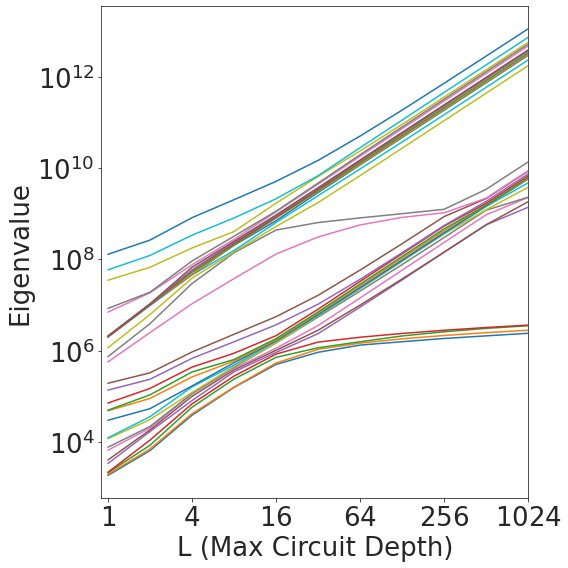

In [76]:
plot_spectra_by_L(fisher_spectra_by_L_full_full,lengths,num_gauge=12, filename='./figure_output/fisher_info_spectra_full_full.png', title='',
                      figure_size=(8,8))

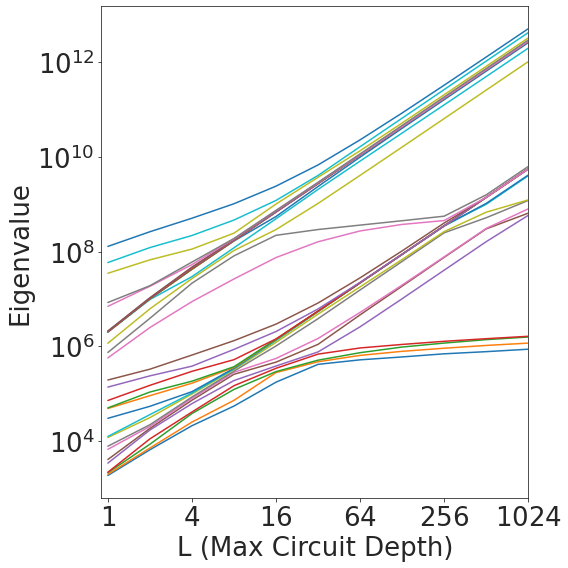

In [77]:
plot_spectra_by_L(fisher_spectra_by_L_full_lite,lengths, num_gauge=12, filename='./figure_output/fisher_info_spectra_full_lite.png', title='',
                      figure_size=(8,8))

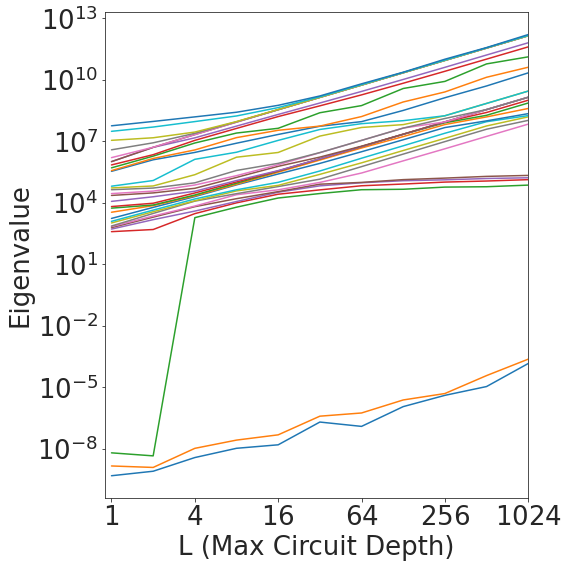

In [78]:
plot_spectra_by_L(fisher_spectra_by_L_pergermpower_lite,lengths, num_gauge=12, filename='./figure_output/fisher_info_spectra_pergerm_lite.png', title='', figure_size=(8,8))

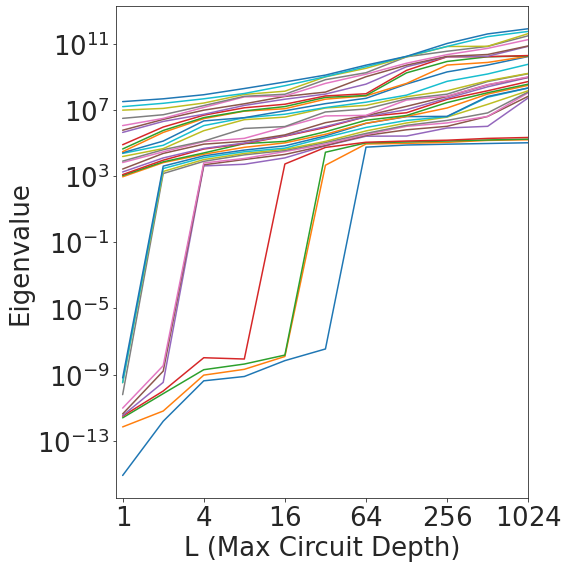

In [79]:
plot_spectra_by_L(fisher_spectra_by_L_pergermrand012_lite,lengths, num_gauge=12, filename='./figure_output/fisher_info_spectra_pergermrand012_lite.png', title='', figure_size=(8,8))

In [80]:
plot_spectra_by_L(fisher_spectra_by_L_pergermrand003_lite,lengths, num_gauge=12, filename='./figure_output/fisher_info_spectra_pergermrand003_lite.png', title='', figure_size=(8,8))

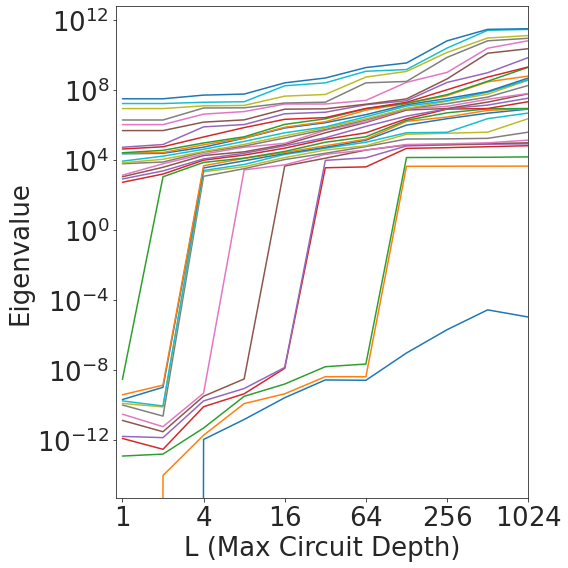

In [81]:
plot_spectra_by_L(fisher_spectra_by_L_pergermrand006_lite,lengths, num_gauge=12, filename='./figure_output/fisher_info_spectra_pergermrand006_lite.png', title='', figure_size=(8,8))

In [82]:
plot_spectra_by_L(fisher_spectra_by_L_pergermrand05_bare,lengths, num_gauge=12, filename='./figure_output/fisher_info_spectra_pergermrand05_bare.png', title='', figure_size=(8,8))

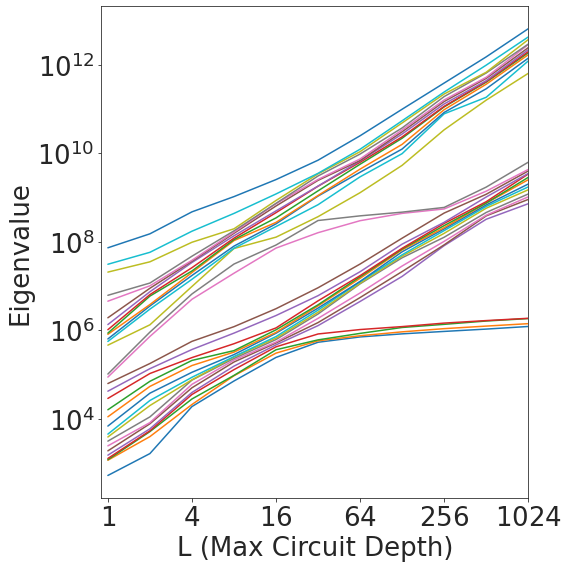

In [83]:
plot_spectra_by_L(fisher_spectra_by_L_pergermrand05_full,lengths, num_gauge=12, filename='./figure_output/fisher_info_spectra_pergermrand05_full.png', title='', figure_size=(8,8))

### What are we missing sensitivity to in the per-germ-power lite experiment design?

Start by confirming that the two lowest parameters that we were expecting to be non-gauge are meaningfully different than the remaining parameters we dropped.

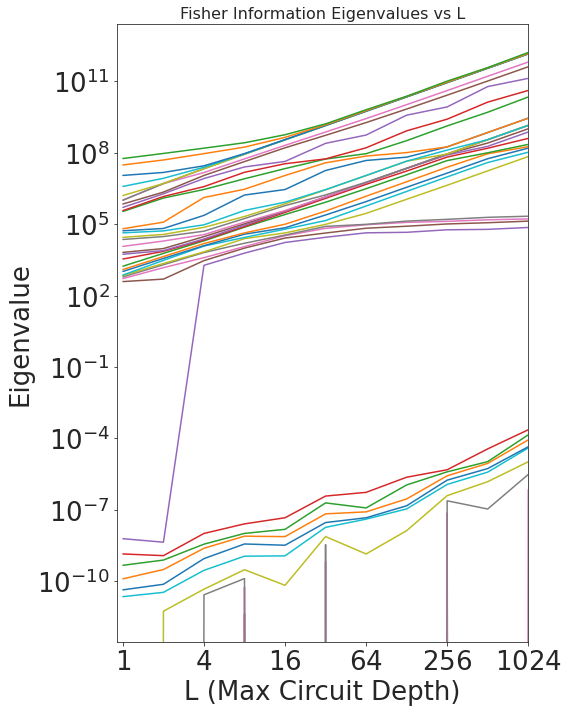

In [84]:
plot_spectra_by_L(fisher_spectra_by_L_pergermpower_lite,lengths, num_gauge=0, filename='./figure_output/fisher_info_spectra_all_pergermpower_lite.png', title='Fisher Information Eigenvalues vs L', figure_size=(8,10))

Answer for posterity, I f'd up the logic for adding back in the additional circuits. It's all good now.

### Let's try to reproduce the drop of in precision we were seeing for the diamond distance scaling using fisher information calculated at a unitarily perturbed point about the target model

Let's use the first of the overrot models we used for the actual datagen for this

In [85]:
#pull out the first of the coherent only models and also set the parameterization to TP
unitarily_perturbed_model=noise_models[('overrot_XYI_1e-2', 0)].copy()
unitarily_perturbed_model.set_all_parameterizations('full TP')
print(unitarily_perturbed_model)

rho0 = TPState with dimension 4
 0.71   0   0 0.71


Mdefault = TPPOVM with effect vectors:
0: FullPOVMEffect with dimension 4
 0.71   0   0 0.71

1: ComplementPOVMEffect with dimension 4
 0.71   0   0-0.71



[] = 
FullTPOp with shape (4, 4)
 1.00   0   0   0
   0 1.00   0   0
   0   0 1.00   0
   0   0   0 1.00


Gxpi2:0 = 
FullTPOp with shape (4, 4)
 1.00   0   0   0
   0 1.00   0   0
   0   0   0-1.00
   0   0 1.00   0


Gypi2:0 = 
FullTPOp with shape (4, 4)
 1.00   0   0   0
   0   0   0 1.00
   0   0 1.00   0
   0-1.00   0   0






In [86]:
#calculate the fisher information with respect to this perturbed model. I don't think we need to regularize this one 
#given the randomness of the noise model.
perturbed_fisher_information_ckt_cache= calculate_fisher_information_per_circuit(unitarily_perturbed_model, comb_edesign['Full', 'Full'].all_circuits_needing_data)
perturbed_fisher_info_by_L_full_lite = calculate_fisher_information_matrices_by_L(unitarily_perturbed_model, comb_edesign['Full', 'Lite'].all_circuits_needing_data, num_shots=1000,
                                                term_cache=perturbed_fisher_information_ckt_cache, regularize_spam=False, cumulative=False)
perturbed_fisher_spectra_by_L_full_lite = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  perturbed_fisher_info_by_L_full_lite.values()]

In [87]:
perturbed_fisher_info_by_L_full_full = calculate_fisher_information_matrices_by_L(unitarily_perturbed_model, comb_edesign['Full', 'Full'].all_circuits_needing_data, num_shots=1000,
                                                term_cache=perturbed_fisher_information_ckt_cache, regularize_spam=False, cumulative=False)

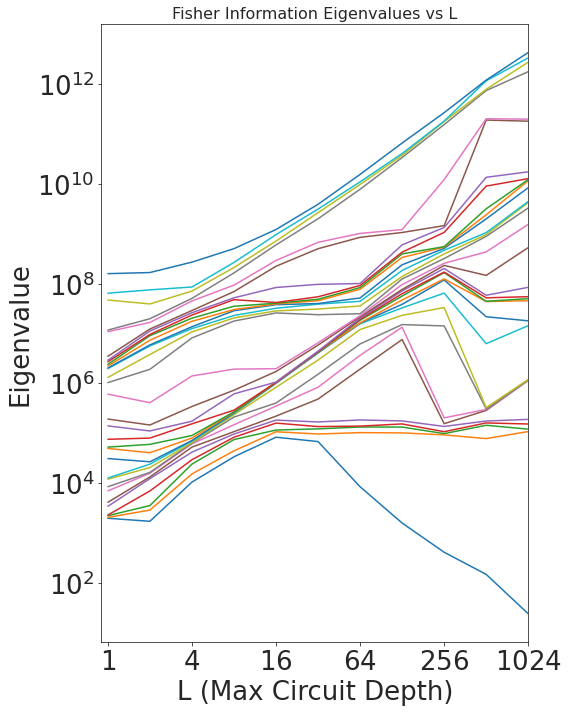

In [88]:
plot_spectra_by_L(perturbed_fisher_spectra_by_L_full_lite,lengths, num_gauge=12, filename='./figure_output/unitarily_perturbed_fisher_info_spectra_full_lite_noaccum.png', title='Fisher Information Eigenvalues vs L',
                      figure_size=(8,10))

In [89]:
unitarily_perturbed_model.parameter_labels

array([(Label('rho0'), 'VecElement 1'), (Label('rho0'), 'VecElement 2'), (Label('rho0'), 'VecElement 3'), (Label('Mdefault'), 'VecElement Re(0)'), (Label('Mdefault'), 'VecElement Re(1)'),
       (Label('Mdefault'), 'VecElement Re(2)'), (Label('Mdefault'), 'VecElement Re(3)'), (Label(()), 'MxElement 1,0'), (Label(()), 'MxElement 1,1'), (Label(()), 'MxElement 1,2'),
       (Label(()), 'MxElement 1,3'), (Label(()), 'MxElement 2,0'), (Label(()), 'MxElement 2,1'), (Label(()), 'MxElement 2,2'), (Label(()), 'MxElement 2,3'), (Label(()), 'MxElement 3,0'),
       (Label(()), 'MxElement 3,1'), (Label(()), 'MxElement 3,2'), (Label(()), 'MxElement 3,3'), (Label(('Gxpi2', 0)), 'MxElement 1,0'), (Label(('Gxpi2', 0)), 'MxElement 1,1'),
       (Label(('Gxpi2', 0)), 'MxElement 1,2'), (Label(('Gxpi2', 0)), 'MxElement 1,3'), (Label(('Gxpi2', 0)), 'MxElement 2,0'), (Label(('Gxpi2', 0)), 'MxElement 2,1'),
       (Label(('Gxpi2', 0)), 'MxElement 2,2'), (Label(('Gxpi2', 0)), 'MxElement 2,3'), (Label(('Gxpi2'

In [90]:
unitarily_perturbed_model.parameter_labels_pretty

['rho0: VecElement 1',
 'rho0: VecElement 2',
 'rho0: VecElement 3',
 'Mdefault: VecElement Re(0)',
 'Mdefault: VecElement Re(1)',
 'Mdefault: VecElement Re(2)',
 'Mdefault: VecElement Re(3)',
 '[]: MxElement 1,0',
 '[]: MxElement 1,1',
 '[]: MxElement 1,2',
 '[]: MxElement 1,3',
 '[]: MxElement 2,0',
 '[]: MxElement 2,1',
 '[]: MxElement 2,2',
 '[]: MxElement 2,3',
 '[]: MxElement 3,0',
 '[]: MxElement 3,1',
 '[]: MxElement 3,2',
 '[]: MxElement 3,3',
 'Gxpi2:0: MxElement 1,0',
 'Gxpi2:0: MxElement 1,1',
 'Gxpi2:0: MxElement 1,2',
 'Gxpi2:0: MxElement 1,3',
 'Gxpi2:0: MxElement 2,0',
 'Gxpi2:0: MxElement 2,1',
 'Gxpi2:0: MxElement 2,2',
 'Gxpi2:0: MxElement 2,3',
 'Gxpi2:0: MxElement 3,0',
 'Gxpi2:0: MxElement 3,1',
 'Gxpi2:0: MxElement 3,2',
 'Gxpi2:0: MxElement 3,3',
 'Gypi2:0: MxElement 1,0',
 'Gypi2:0: MxElement 1,1',
 'Gypi2:0: MxElement 1,2',
 'Gypi2:0: MxElement 1,3',
 'Gypi2:0: MxElement 2,0',
 'Gypi2:0: MxElement 2,1',
 'Gypi2:0: MxElement 2,2',
 'Gypi2:0: MxElement 2,3',
 'G

In [91]:
#write a function for projecting onto a subspace of parameter space corresponding to a particular gate.
def project_onto_gate_subspace(mx, model, gate):
    #gate should be specified as it's string formatted version.
    
    #special handling for the identity gate
    if gate=='Gi':
        gate= 'COMPOUND'
    #Start by pulling out a list of parameter labels from the model.
    param_labels= model.parameter_labels
    #this set of parameter labels is given by an array of tuples with the first element being a gate/SPAM label and the second being a description.
    #let's just use list comprehension to pick out the indices we want.
    gate_indices= [i for i in range(len(param_labels)) if param_labels[i][0].name==gate]
    
    #ok, so we now know which of the model parameter indices we want to project onto, let's construct a projector onto this subspace.
    #Now what we want to do is identify a basis for this subspace, then arrange those basis vectors into the column vectors of a a matrix A.
    #Then the projection matrix A(A^T A)^–1 A^T projects a vector onto this subspace.
    num_basis_vecs= len(gate_indices)
    
    A= np.zeros((model.num_params, num_basis_vecs))
    for i, idx in enumerate(gate_indices):
        A[idx,i]=1
        
    #now form the projection matrix:
    projector= A@(np.linalg.inv(np.transpose(A)@A))@np.transpose(A)
        
    #apply the projector to the fisher information matrix.
    projected_mx=projector@mx@projector
    
    #return just the non-trivial block
    nontrivial_projected_mx=np.reshape(np.extract(projected_mx,projected_mx), (num_basis_vecs,num_basis_vecs))
    
    return nontrivial_projected_mx

In [92]:
#write a function for projecting onto a subspace of parameter space corresponding to a particular gate.
def project_vecs_onto_gate_subspace(vecs, model, gate):
    #gate should be specified as it's string formatted version.
    #project a list of vectors onto a gate subspace
    #vecs should be a matrix whose column vectors we want to project.
    
    #special handling for the identity gate
    if gate=='Gi':
        gate= 'COMPOUND'
    #Start by pulling out a list of parameter labels from the model.
    param_labels= model.parameter_labels
    #this set of parameter labels is given by an array of tuples with the first element being a gate/SPAM label and the second being a description.
    #let's just use list comprehension to pick out the indices we want.
    gate_indices= [i for i in range(len(param_labels)) if param_labels[i][0].name==gate]
    
    #ok, so we now know which of the model parameter indices we want to project onto, let's construct a projector onto this subspace.
    #Now what we want to do is identify a basis for this subspace, then arrange those basis vectors into the column vectors of a a matrix A.
    #Then the projection matrix A(A^T A)^–1 A^T projects a vector onto this subspace.
    num_basis_vecs= len(gate_indices)
    
    A= np.zeros((model.num_params, num_basis_vecs))
    for i, idx in enumerate(gate_indices):
        A[idx,i]=1
        
    #now form the projection matrix:
    projector= A@(np.linalg.inv(np.transpose(A)@A))@np.transpose(A)
        
    #apply the projector to the fisher information matrix.
    projected_vecs= projector@vecs
    
    #return just the non-trivial block
    nontrivial_projected_mx=np.reshape(np.extract(projected_mx,projected_mx), (num_basis_vecs,num_basis_vecs))
    
    return nontrivial_projected_mx

In [93]:
unitarily_perturbed_model.parameter_labels[20][0].name

'Gxpi2'

In [94]:
#project each of the fisher information matrices by L onto the Gi subspace.
Gi_projected_fisher_mxs=[project_onto_gate_subspace(perturbed_fisher_info_by_L_full_lite[L], unitarily_perturbed_model, 'Gi') for L in lengths]
print(Gi_projected_fisher_mxs)

[array([[ 2.332990e+06,  2.305442e+05, -1.737529e+04,  1.055686e+04,  2.168569e+03, -1.190161e+03, -2.625665e+02, -2.122741e+01,  3.920806e+04,  3.511108e+03, -2.889274e+02,  3.884062e+03],
       [ 2.305442e+05,  2.323389e+06, -7.507151e+02, -2.463591e+04, -1.190161e+03,  3.049945e+03,  1.132859e+01, -4.191257e+01,  3.511108e+03,  2.472435e+04, -1.515919e+01, -1.892953e+02],
       [-1.737529e+04, -7.507151e+02,  4.190524e+03, -1.213639e+02, -2.625665e+02,  1.132859e+01, -6.584572e+02,  1.096443e+01, -2.889274e+02, -1.515919e+01,  1.440763e+02,  8.175332e+01],
       [ 1.055686e+04, -2.463591e+04, -1.213639e+02,  4.514885e+03, -2.122741e+01, -4.191257e+01,  1.096443e+01, -2.237511e+02,  3.884062e+03, -1.892953e+02,  8.175332e+01,  1.432459e+04],
       [ 2.168569e+03, -1.190161e+03, -2.625665e+02, -2.122741e+01,  1.657320e+06, -1.074653e+04, -3.214709e+05, -7.926684e+03,  5.762621e+03, -9.417725e+01, -5.022390e+03, -4.925286e+03],
       [-1.190161e+03,  3.049945e+03,  1.132859e+01, -

In [95]:
Gi_projected_perturbed_fisher_spectra_by_L_full_lite = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  Gi_projected_fisher_mxs]

In [96]:
print(Gi_projected_perturbed_fisher_spectra_by_L_full_lite)

[array([   3923.977522,    4006.403006,    4027.881122,    4166.851398,    4231.170843,    4288.258362, 1331553.254099, 1973067.510437, 2019955.9665  , 2101002.521532, 2559288.4205  , 3748577.144331]), array([   15699.573642,    16028.732459,    16111.106275,    16488.661164,    16751.011485,    16891.358123,  4084075.929451,  5609106.306632,  5884222.685168,  6711546.069648,  7641962.855768,
       11403242.969038]), array([   62839.12102 ,    64143.629844,    64428.959384,    65006.067288,    65916.777099,    66457.489383,  9993441.026385, 12356208.400389, 13437652.007422, 16838362.10391 , 17658107.135091,
       24052801.919722]), array([  251863.733119,   256452.260117,   257083.5714  ,   258176.940811,   260393.504955,   263912.258164, 18318996.937936, 20546186.548875, 23174364.926733, 29754599.128451, 30330855.807772,
       34512191.529711]), array([ 1013475.041085,  1024619.843836,  1033028.394866,  1037506.751938,  1046641.51185 ,  1062293.230921, 25891950.183789, 28394500.695

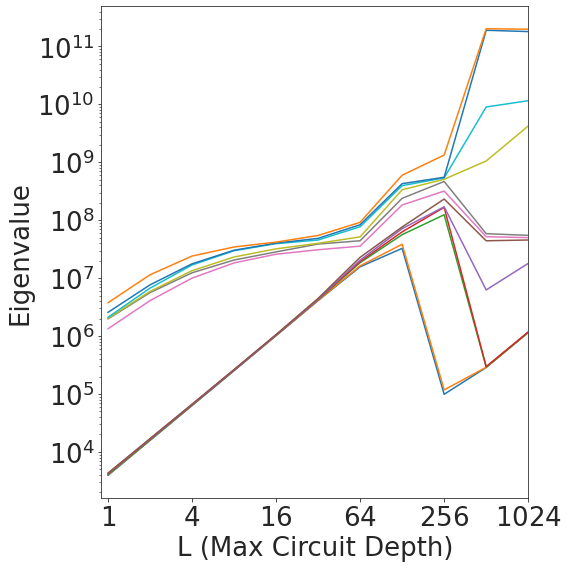

In [97]:
plot_spectra_by_L(Gi_projected_perturbed_fisher_spectra_by_L_full_lite,lengths, num_gauge=0, filename='./figure_output/Gi_projected_unitarily_perturbed_fisher_info_spectra_full_lite_noaccum.png', title='',
                      figure_size=(8,8))

In [98]:
#project each of the fisher information matrices by L onto the Gxpi2 subspace.
Gxpi2_projected_fisher_mxs=[project_onto_gate_subspace(perturbed_fisher_info_by_L_full_lite[L], unitarily_perturbed_model, 'Gxpi2') for L in lengths]
Gxpi2_projected_perturbed_fisher_spectra_by_L_full_lite = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  Gxpi2_projected_fisher_mxs]

In [99]:
plot_spectra_by_L(Gxpi2_projected_perturbed_fisher_spectra_by_L_full_lite,lengths, num_gauge=0, filename='./figure_output/Gxpi2_projected_unitarily_perturbed_fisher_info_spectra_full_lite_noaccum.png', title='',
                      figure_size=(8,8))

In [100]:
#project each of the fisher information matrices by L onto the Gxpi2 subspace.
Gypi2_projected_fisher_mxs=[project_onto_gate_subspace(perturbed_fisher_info_by_L_full_lite[L], unitarily_perturbed_model, 'Gypi2') for L in lengths]
Gypi2_projected_perturbed_fisher_spectra_by_L_full_lite = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  Gypi2_projected_fisher_mxs]

In [101]:
np.asarray(Gypi2_projected_fisher_mxs)[:,0,0]

array([5.411096e+06, 5.314804e+06, 1.059583e+07, 2.661505e+07, 7.645356e+07, 1.478803e+08, 2.205675e+08, 2.679624e+08, 3.565518e+08, 7.732731e+08, 3.108162e+09])

In [102]:
np.linalg.eig(Gypi2_projected_fisher_mxs[0])

(array([8.273711e+07, 7.854661e+06, 3.012941e+06, 2.397856e+06, 1.055096e+05, 1.356807e+04, 6.486536e-01, 1.046656e+04, 9.259426e+03, 3.462382e+03, 5.005105e+03, 5.193817e+03]),
 array([[ 1.411866e-01, -6.912303e-01, -9.728807e-03, -7.401417e-03, -1.388177e-01, -6.776986e-01, -4.828600e-03, -1.339199e-01,  2.171724e-02, -7.138054e-02, -6.870867e-03,  2.643747e-05],
        [ 7.849602e-03,  2.716873e-03,  1.077330e-03,  1.164714e-03, -4.602931e-01,  1.661837e-01, -8.297730e-03,  8.590716e-02,  2.272309e-03, -8.561614e-01,  2.617336e-02, -1.388893e-01],
        [ 4.299467e-03,  6.383669e-03, -7.183026e-04,  8.491903e-04, -2.842640e-03,  2.883066e-03, -2.576198e-03,  1.216419e-02,  4.964127e-01, -2.395613e-02,  8.032035e-01,  3.280749e-01],
        [ 6.931529e-01,  1.389647e-01,  6.337200e-03,  5.256380e-03,  1.042502e-02,  4.157069e-03, -7.070445e-01,  1.399642e-03, -4.386816e-03,  8.513235e-03, -4.947899e-03,  2.035264e-03],
        [-6.552227e-03, -2.720983e-02,  7.583221e-01,  6.51205

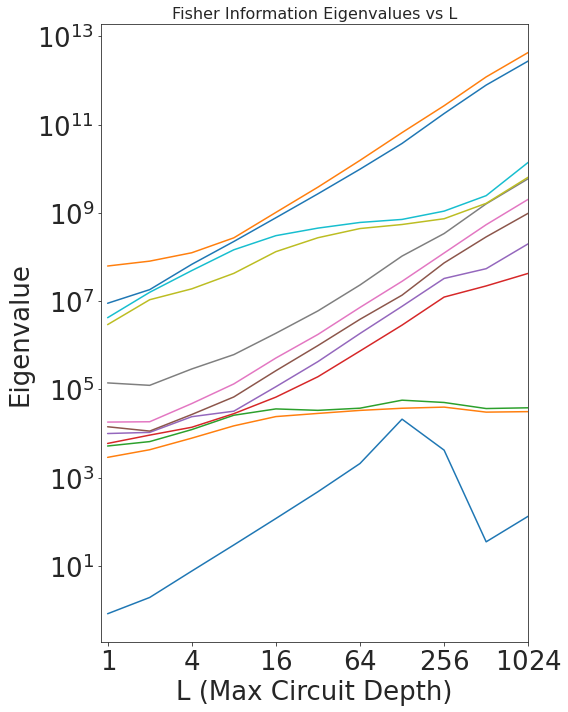

In [103]:
plot_spectra_by_L(Gxpi2_projected_perturbed_fisher_spectra_by_L_full_lite,lengths, num_gauge=0, filename='./figure_output/Gypi2_projected_unitarily_perturbed_fisher_info_spectra_full_lite.png', title='Fisher Information Eigenvalues vs L',
                      figure_size=(8,10))

In [104]:
Gi_projected_fisher_mxs_full_full=[project_onto_gate_subspace(perturbed_fisher_info_by_L_full_full[L], unitarily_perturbed_model, 'Gi') for L in lengths]
Gi_projected_perturbed_fisher_spectra_by_L_full_full = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  Gi_projected_fisher_mxs_full_full]
Gxpi2_projected_fisher_mxs_full_full=[project_onto_gate_subspace(perturbed_fisher_info_by_L_full_full[L], unitarily_perturbed_model, 'Gxpi2') for L in lengths]
Gxpi2_projected_perturbed_fisher_spectra_by_L_full_full = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  Gxpi2_projected_fisher_mxs_full_full]

In [105]:
plot_spectra_by_L(Gi_projected_perturbed_fisher_spectra_by_L_full_full,lengths, num_gauge=0, filename='./figure_output/Gi_projected_unitarily_perturbed_fisher_info_spectra_full_full_noaccum.png', title='',
                      figure_size=(8,8))

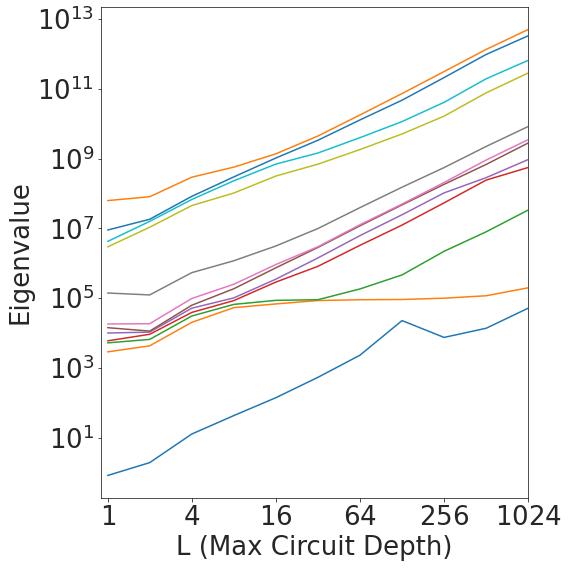

In [106]:
plot_spectra_by_L(Gxpi2_projected_perturbed_fisher_spectra_by_L_full_full,lengths, num_gauge=0, filename='./figure_output/Gxpi2_projected_unitarily_perturbed_fisher_info_spectra_full_full_noaccum.png', title='',
                      figure_size=(8,8))

How about some state prep too?

In [107]:
#project each of the fisher information matrices by L onto the Gi subspace.
Stateprep_projected_fisher_mxs=[project_onto_gate_subspace(perturbed_fisher_info_by_L_full_lite[L], unitarily_perturbed_model, 'rho0') for L in lengths]
print(Stateprep_projected_fisher_mxs)

[array([[ 7.493096e+04, -2.701785e+03, -8.403936e+04],
       [-2.701785e+03,  7.702291e+04, -2.717108e+05],
       [-8.403936e+04, -2.717108e+05,  4.167363e+07]]), array([[ 5.722432e+04,  5.677143e+02,  5.190530e+04],
       [ 5.677143e+02,  6.878433e+04, -9.373087e+04],
       [ 5.190530e+04, -9.373087e+04,  3.379846e+07]]), array([[ 9.427408e+04, -6.549191e+03, -6.428215e+04],
       [-6.549191e+03,  1.064595e+05, -3.102637e+05],
       [-6.428215e+04, -3.102637e+05,  4.323895e+07]]), array([[ 1.450023e+05, -3.797939e+03, -1.009129e+05],
       [-3.797939e+03,  1.469820e+05, -6.039553e+05],
       [-1.009129e+05, -6.039553e+05,  4.416957e+07]]), array([[ 1.511035e+05, -4.624228e+03, -7.762391e+04],
       [-4.624228e+03,  1.584191e+05, -4.469737e+05],
       [-7.762391e+04, -4.469737e+05,  3.433998e+07]]), array([[ 1.541841e+05, -2.824560e+03, -6.760135e+03],
       [-2.824560e+03,  1.650911e+05, -4.234703e+05],
       [-6.760135e+03, -4.234703e+05,  2.162943e+07]]), array([[ 1.5904

In [108]:
Stateprep_projected_perturbed_fisher_spectra_by_L_full_lite = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  Stateprep_projected_fisher_mxs]

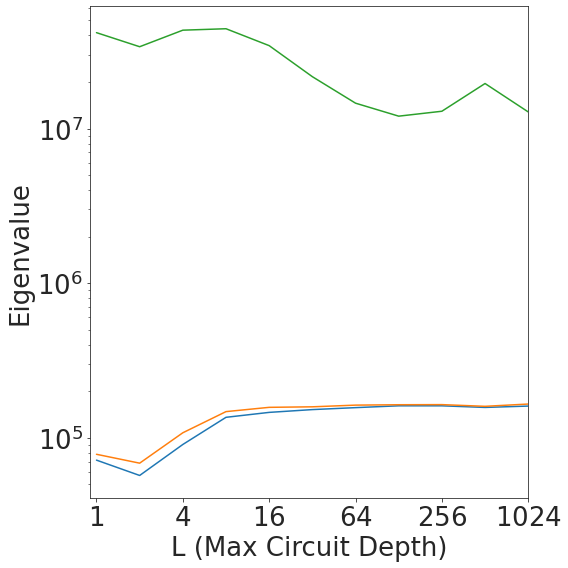

In [109]:
plot_spectra_by_L(Stateprep_projected_perturbed_fisher_spectra_by_L_full_lite,lengths, num_gauge=0, filename='./figure_output/Stateprep_projected_unitarily_perturbed_fisher_info_spectra_full_lite_noaccum.png', title='',
                      figure_size=(8,8))

[array([[ 4.184164e+07, -1.185221e+05, -1.552175e+05,  1.950310e+06],
       [-1.185221e+05,  7.412922e+04,  5.567277e+03,  4.688576e+05],
       [-1.552175e+05,  5.567277e+03,  7.782465e+04,  6.418112e+05],
       [ 1.950310e+06,  4.688576e+05,  6.418112e+05,  4.167363e+07]]), array([[ 3.393749e+07,  3.744455e+04,  5.214120e+04, -3.099890e+06],
       [ 3.744455e+04,  6.011463e+04,  2.898087e+03,  3.599158e+05],
       [ 5.214120e+04,  2.898087e+03,  6.589401e+04,  5.118952e+05],
       [-3.099890e+06,  3.599158e+05,  5.118952e+05,  3.379846e+07]]), array([[ 4.345636e+07, -1.294523e+04, -1.132577e+05,  1.490049e+06],
       [-1.294523e+04,  9.306630e+04,  5.721178e+03,  4.242995e+05],
       [-1.132577e+05,  5.721178e+03,  1.076673e+05,  7.458717e+05],
       [ 1.490049e+06,  4.242995e+05,  7.458717e+05,  4.323895e+07]]), array([[ 4.447862e+07, -1.298685e+05, -3.627155e+04,  2.822001e+05],
       [-1.298685e+05,  1.410420e+05,  6.005313e+03,  5.066429e+05],
       [-3.627155e+04,  6.0

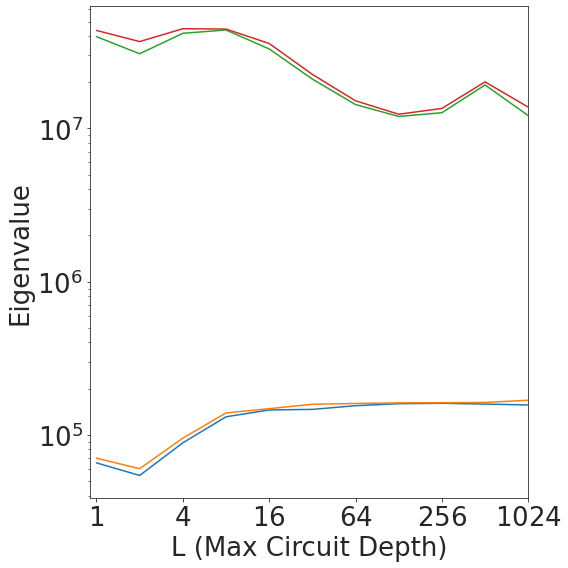

In [110]:
#project each of the fisher information matrices by L onto the Gi subspace.
Meas_projected_fisher_mxs=[project_onto_gate_subspace(perturbed_fisher_info_by_L_full_lite[L], unitarily_perturbed_model, 'Mdefault') for L in lengths]
print(Meas_projected_fisher_mxs)
Meas_projected_perturbed_fisher_spectra_by_L_full_lite = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  Meas_projected_fisher_mxs]
plot_spectra_by_L(Meas_projected_perturbed_fisher_spectra_by_L_full_lite,lengths, num_gauge=0, filename='./figure_output/Meas_projected_unitarily_perturbed_fisher_info_spectra_full_lite_noaccum.png', title='',
                      figure_size=(8,8))

Look at some eigenvectors too.

In [111]:
Gi_projected_fisher_eigvecs= [np.linalg.eigh(proj_fisher_mx)[1] for proj_fisher_mx in Gi_projected_fisher_mxs]
#print(Gi_projected_fisher_eigvecs)

In [112]:
print(Gi_projected_perturbed_fisher_spectra_by_L_full_lite[-1][-1])
print(Gi_projected_fisher_eigvecs[-1][:,-1])

198252681368.93463
[-0.651305  0.123789  0.013263  0.010346  0.450698 -0.013161  0.123642  0.015245 -0.571008 -0.010595 -0.015121  0.122402]


In [113]:
print(Gi_projected_perturbed_fisher_spectra_by_L_full_lite[-1][-2])
print(Gi_projected_fisher_eigvecs[-1][:,-2])

180641189471.0408
[ 0.143113  0.559908  0.049157  0.066882 -0.099435 -0.076552  0.552187  0.0602    0.127233 -0.03227  -0.084138  0.557262]


In [114]:
#from pygsti.baseobjs import Label
#np.linalg.eigh(unitarily_perturbed_model.operations[Label(())].to_dense())

In [115]:
print(Gi_projected_perturbed_fisher_spectra_by_L_full_lite[-1][-3])
print(Gi_projected_fisher_eigvecs[-1][:,-3])

11569706725.221268
[ 0.007319 -0.092209  0.421285 -0.444373 -0.002257  0.334924  0.123567  0.378265  0.003123 -0.515449  0.283309  0.001453]


Maybe look at condition numbers?

In [116]:
Gi_projected_cond_full_lite= [np.linalg.cond(proj_fisher) for proj_fisher in Gi_projected_fisher_mxs]

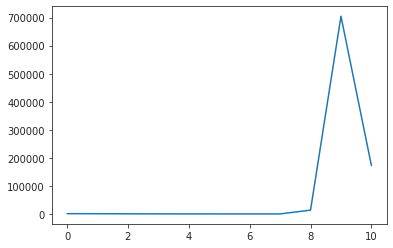

In [117]:
plt.plot(Gi_projected_cond_full_lite)

### How about plotting derivatives instead? May be easier to pick out plateuing eigenvalues.

In [118]:
perturbed_fisher_info_by_L_full_lite_cum = calculate_fisher_information_matrices_by_L(unitarily_perturbed_model, comb_edesign['Full', 'Lite'].all_circuits_needing_data, num_shots=1000,
                                                term_cache=perturbed_fisher_information_ckt_cache, regularize_spam=False, cumulative=True)
perturbed_fisher_spectra_by_L_full_lite_cum = [ np.linalg.eigvalsh(fisher_at_L)[12:] for fisher_at_L in  perturbed_fisher_info_by_L_full_lite_cum.values()]
log_perturbed_fisher_spectra_by_L_full_lite_cum= [np.log(evals) for evals in perturbed_fisher_spectra_by_L_full_lite_cum]

In [119]:
#print(perturbed_fisher_spectra_by_L_full_lite_cum)
print(log_perturbed_fisher_spectra_by_L_full_lite_cum)

[array([ 7.59243 ,  7.631653,  7.709927,  7.740922,  8.142575,  8.329048,  8.856081,  9.047549,  9.395428,  9.449259, 10.348762, 10.815128, 10.876061, 11.237592, 11.85494 , 12.171162, 13.321283,
       13.852312, 14.092105, 14.500486, 14.527047, 14.616786, 14.694363, 14.812544, 14.883063, 15.065138, 16.204243, 16.277297, 17.666108, 17.981574, 18.881806]), array([ 8.916269,  8.929463,  9.165994,  9.388213,  9.749752,  9.921961,  9.959522, 10.073701, 10.367189, 10.544047, 10.97691 , 11.459624, 11.697355, 11.976229, 12.437188, 12.742397, 14.954833,
       15.215682, 15.503146, 15.854649, 15.936172, 16.127311, 16.306825, 16.429035, 16.541747, 16.632977, 17.111094, 17.19668 , 18.262299, 18.743531, 19.590119]), array([10.157336, 10.364772, 10.706037, 10.814138, 11.129316, 11.217091, 11.342047, 11.36624 , 11.507415, 11.610388, 11.716286, 12.111755, 12.241645, 12.663535, 13.011515, 13.498623, 16.10267 ,
       16.425864, 16.691245, 16.832276, 16.937422, 17.144413, 17.355353, 17.547858, 17.6794

In [120]:
#Take the derivative of the log of the fisher info
deriv_perturbed_log_fisher_full_lite= [np.diff(log_evals) for log_evals in log_perturbed_fisher_spectra_by_L_full_lite_cum]

In [121]:
print(deriv_perturbed_log_fisher_full_lite)

[array([0.039223, 0.078274, 0.030995, 0.401653, 0.186473, 0.527032, 0.191469, 0.347878, 0.053831, 0.899503, 0.466367, 0.060933, 0.361531, 0.617348, 0.316222, 1.150121, 0.531029, 0.239793, 0.408381,
       0.026562, 0.089739, 0.077577, 0.118181, 0.070518, 0.182075, 1.139105, 0.073053, 1.388811, 0.315467, 0.900232]), array([0.013194, 0.236531, 0.222219, 0.361539, 0.172209, 0.037561, 0.114179, 0.293489, 0.176857, 0.432864, 0.482713, 0.237731, 0.278874, 0.460958, 0.305209, 2.212436, 0.26085 , 0.287464, 0.351503,
       0.081523, 0.191139, 0.179514, 0.12221 , 0.112713, 0.09123 , 0.478116, 0.085586, 1.065619, 0.481232, 0.846588]), array([0.207437, 0.341265, 0.108101, 0.315178, 0.087775, 0.124956, 0.024193, 0.141175, 0.102973, 0.105898, 0.395469, 0.12989 , 0.421889, 0.347981, 0.487108, 2.604047, 0.323194, 0.265381, 0.141031,
       0.105146, 0.206991, 0.21094 , 0.192505, 0.131553, 0.06775 , 0.280137, 0.372027, 0.335017, 0.441065, 1.005968]), array([0.244703, 0.516887, 0.111271, 0.268588, 0.26

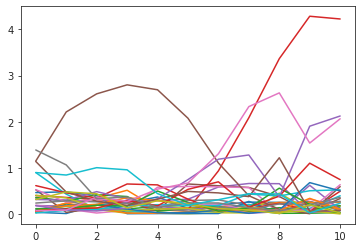

In [122]:
plt.plot(deriv_perturbed_log_fisher_full_lite)

# Plots for the Diamond Distance vs. Total Number of Circuits Comparing the different experiment designs

In [123]:
def plot_ddists_vs_num_circuits(ensemble_ddist_lists, L_dicts, labels, styles, title, ylabel, filename, figure_size=None, leg_loc=None, 
                                annotation1=None, annotation2=None, ncol=1, leg_fontsize=14, markersizes=None):
    
    
    #marker_list = ['o', 'v', '^', '<', '>' , 's', 'p', 'P', '*', 'D', 'X', 'h']
    
    if figure_size is not None:
        plt.figure(figsize=figure_size)
    
    for ensemble_ddists, L_dict, term_styles, term_labels, marker_size in zip(ensemble_ddist_lists, L_dicts, styles, labels, markersizes):
        lengths = list(L_dict.keys())
        eff_xs = list(L_dict.values())

        avgs = np.mean(ensemble_ddists, axis=0)
        stds = np.std(ensemble_ddists, axis=0)
        
        plt.errorbar(eff_xs, avgs, yerr=stds, fmt=term_styles, label=term_labels, markersize=marker_size, capsize=2)

    axes = plt.gca()
    axes.set_xscale('log')
    axes.minorticks_off()
    axes.set_yscale('log')
    axes.set_ylim([1e-5, 1e-1])

    plt.grid()
    #plt.legend(ncol=2, loc='lower left')
    
    if leg_loc is None:
        if ncol is None:
            plt.legend(loc='upper left', ncol=1, fontsize=leg_fontsize)
        else:
            plt.legend(loc='upper left', ncol=ncol, fontsize=leg_fontsize)
    else:
        if ncol is None:
            plt.legend(loc=leg_loc, ncol=1, fontsize=leg_fontsize)
        else:
            plt.legend(loc=leg_loc, ncol=ncol, fontsize=leg_fontsize)
        
    plt.title(title, fontsize=16)
    plt.xlabel('Number of Circuits', fontsize=26)
    plt.xlim([60, .6e4])
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.ylabel(ylabel, fontsize=26)
    
    plt.minorticks_on()
    
    if annotation1 is not None:
        plt.annotate(annotation1[0], annotation1[1], xytext= annotation1[2], arrowprops= annotation1[3], fontsize=18)
    
    if annotation2 is not None:
        plt.annotate(annotation2[0], annotation2[1], xytext= annotation2[2], arrowprops= annotation2[3], fontsize=18)
    
    plt.tight_layout()
    plt.savefig(filename, facecolor='white', dpi=128)
    plt.show()

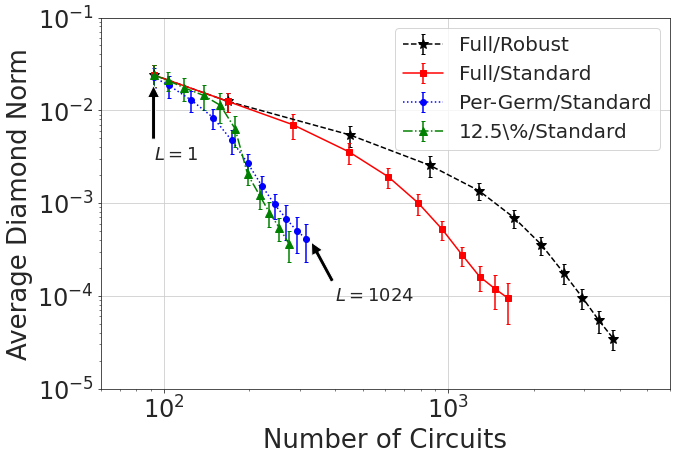

In [124]:
ff_shots = get_shot_counts_by_L(comb_edesign['Full','Full'], num_shots=1)
fl_shots = get_shot_counts_by_L(comb_edesign['Full','Lite'], num_shots=1)
pgl_shots = get_shot_counts_by_L(comb_edesign['PerGermPower', 'Lite'], num_shots=1)
pg125l_shots = get_shot_counts_by_L(comb_edesign['PerGermRand0.12-0', 'Lite'], num_shots=1)

plot_ddists_vs_num_circuits([avg_gateset_ddists_full_full_TP_coher, avg_gateset_ddists_full_lite_TP_coher,
                             avg_gateset_ddists_pergermpower_lite_TP_coher, avg_gateset_ddists_pergermrand012_lite_TP_coher],
               [ff_shots, fl_shots, pgl_shots, pg125l_shots],
               ['Full/Robust', 'Full/Standard', 'Per-Germ/Standard', '12.5\%/Standard'],
               ['k--*', 'r-s', 'b:o', 'g-.^'], '', 'Average Diamond Norm', './figure_output/ddists_vs_numckts_ddists_TP_coher.png', 
               figure_size=(9.5,6.5), annotation1=(r'$L=1$', (list(pgl_shots.values())[0], 0.02), (92, 3e-3), dict(facecolor='black', shrink=0.05)),
               annotation2=(r'$L=1024$', (list(pgl_shots.values())[-1]+10, .4e-3), (400, .9e-4), dict(facecolor='black', shrink=0.05)), leg_fontsize=20, leg_loc='upper right',
               markersizes=[11,6,6, 8])

# Related analysis could be resource estimation, i.e., time to execute edesign on x-axis instead of number of circuits only
# (to take into account longer circuits at high L)

# Maybe even put LGST on this figure as a reference

In [125]:
print('Avg Gateset Diamond Dist Full Full: ', avg_avg_gateset_ddists_full_full_TP_coher)
print('Avg Gateset Diamond Dist Per-Germ Lite: ', avg_avg_gateset_ddists_pergermpower_lite_TP_coher)
print('Avg Gateset Diamond Dist Full Lite: ', avg_avg_gateset_ddists_full_lite_TP_coher)
print('Avg Gateset Diamond Dist 12.5% Lite: ', avg_avg_gateset_ddists_pergermrand012_lite_TP_coher)

print('Full-Lite Num Ckts by L: ', ff_shots)
print('Full-Lite Num Ckts by L: ', fl_shots)
print('Per-Germ-Lite Num Ckts by L: ', pgl_shots)
print('Per-Germ Random 12.5%-Lite Num Ckts by L: ', pg125l_shots)

Avg Gateset Diamond Dist Full Full:  [2.405305e-02 1.246701e-02 5.433827e-03 2.547579e-03 1.358841e-03 6.954286e-04 3.572353e-04 1.772912e-04 9.579105e-05 5.447350e-05 3.465957e-05]
Avg Gateset Diamond Dist Per-Germ Lite:  [0.022816 0.018607 0.012836 0.008347 0.004758 0.0027   0.001539 0.000968 0.00068  0.000503 0.000412]
Avg Gateset Diamond Dist Full Lite:  [2.405305e-02 1.246701e-02 6.963640e-03 3.560183e-03 1.913901e-03 1.001747e-03 5.209245e-04 2.746310e-04 1.614856e-04 1.198128e-04 9.388978e-05]
Avg Gateset Diamond Dist 12.5% Lite:  [0.024053 0.021066 0.017455 0.014451 0.011307 0.006322 0.002044 0.001214 0.000789 0.000538 0.000365]
Full-Lite Num Ckts by L:  {1: 92, 2: 168, 4: 450, 8: 862, 16: 1282, 32: 1702, 64: 2122, 128: 2542, 256: 2962, 512: 3382, 1024: 3802}
Full-Lite Num Ckts by L:  {1: 92, 2: 168, 4: 285, 8: 448, 16: 616, 32: 784, 64: 952, 128: 1120, 256: 1288, 512: 1456, 1024: 1624}
Per-Germ-Lite Num Ckts by L:  {1: 92, 2: 104, 4: 125, 8: 149, 16: 173, 32: 197, 64: 221, 128

In [126]:
#len(list(comb_edesign['PerGermPower', 'Lite'].all_circuits_needing_data._additional_circuits))

In [127]:
#get_shot_counts_by_L(comb_edesign['PerGermPower', 'Lite'], num_shots=1)